# Проект поиска профитной торговой стратегии на криптобирже

## Задача

* **Проанализировать 3 самые популярные торговые метрики по мнению Тинькофф инвестиций (https://www.tbank.ru/invest/help/educate/trading/) и влияние их сигналов на вероятность извлечения дохода из позиции**
* **По возможности обучить модель, которую можно будет применить для торговли**

## План работы

* **Загрузить данные** Это будут историчейские данные по ценам SOL загруженные с биржы Bybit за несколько месяцев (https://www.bybit.com/derivatives/en/history-data)
* **Проверка данных на корректность загрузки**
* **Предобработка данных**
* **Исследовательский анализ**
* **Подготовка данных для ML**
* **Обучение моделей**
* **Анализ результатов моделей**
* **Вывод**

### Импорты

In [8]:
import pandas as pd
import sklearn
import talib
import torch
import matplotlib.pyplot as plt
import seaborn as sn
import shap
import numpy as np
import phik

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    OneHotEncoder,
    OrdinalEncoder
)

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import lightgbm as lgb

from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [9]:
RANDOM_STATE = 42

In [10]:
pd.options.display.max_columns = 100

## Загрузка данных

In [12]:
col_names = ['date_time','open_price','high_price','low_price','close_price','trade_volume']

In [13]:
date_col = ['date_time']

In [14]:
sol_data_01 = pd.read_csv("H:\SOLUSDT_15_2024-01-01_2024-01-31.csv", names=col_names, parse_dates=date_col)

In [15]:
sol_data_02 = pd.read_csv("H:\SOLUSDT_15_2024-02-01_2024-02-29.csv", names=col_names, parse_dates=date_col)

In [16]:
sol_data_03 = pd.read_csv("H:\SOLUSDT_15_2024-03-01_2024-03-31.csv", names=col_names, parse_dates=date_col)

In [17]:
sol_data_04 = pd.read_csv("H:\SOLUSDT_15_2024-04-01_2024-04-30.csv", names=col_names, parse_dates=date_col)

In [18]:
sol_data_05 = pd.read_csv("H:\SOLUSDT_15_2024-05-01_2024-05-31.csv", names=col_names, parse_dates=date_col)

In [19]:
sol_data_06 = pd.read_csv("H:\SOLUSDT_15_2024-06-01_2024-06-30.csv", names=col_names, parse_dates=date_col)

In [20]:
sol_data_07 = pd.read_csv("H:\SOLUSDT_15_2024-07-01_2024-07-31.csv", names=col_names, parse_dates=date_col)

In [21]:
sol_data_08 = pd.read_csv("H:\SOLUSDT_15_2024-08-01_2024-08-31.csv", names=col_names, parse_dates=date_col)

## Проверка загруженных данных

### Sol_data_01

In [24]:
sol_data_01.head()

,date_time,open_price,high_price,low_price,close_price,trade_volume
0,2024-01-01 00:00:00,104.967,105.072,104.610,104.770,25264.8
1,2024-01-01 00:15:00,104.770,105.270,104.676,104.697,32520.8
2,2024-01-01 00:30:00,104.697,105.043,104.573,104.856,15338.8
3,2024-01-01 00:45:00,104.856,104.859,103.703,103.997,67318.4
4,2024-01-01 01:00:00,103.997,104.112,103.191,103.456,48060.8


In [25]:
sol_data_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2977 entries, 0 to 2976
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_time     2977 non-null   datetime64[ns]
 1   open_price    2977 non-null   float64       
 2   high_price    2977 non-null   float64       
 3   low_price     2977 non-null   float64       
 4   close_price   2977 non-null   float64       
 5   trade_volume  2977 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 139.7 KB


In [26]:
sol_data_01.shape

(2977, 6)

### Sol_data_02

In [28]:
sol_data_02.head()

,date_time,open_price,high_price,low_price,close_price,trade_volume
0,2024-02-01 00:00:00,97.972,98.441,97.741,98.208,177060.3
1,2024-02-01 00:15:00,98.208,98.703,95.772,95.857,515291.7
2,2024-02-01 00:30:00,95.857,97.164,95.809,97.128,228494.7
3,2024-02-01 00:45:00,97.128,97.200,96.521,97.181,140837.2
4,2024-02-01 01:00:00,97.181,97.347,96.229,97.300,150536.9


In [29]:
sol_data_02.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2785 entries, 0 to 2784
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_time     2785 non-null   datetime64[ns]
 1   open_price    2785 non-null   float64       
 2   high_price    2785 non-null   float64       
 3   low_price     2785 non-null   float64       
 4   close_price   2785 non-null   float64       
 5   trade_volume  2785 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 130.7 KB


In [30]:
sol_data_02.shape

(2785, 6)

### Sol_data_03

In [32]:
sol_data_03.head()

,date_time,open_price,high_price,low_price,close_price,trade_volume
0,2024-03-01 00:00:00,130.655,130.696,127.548,128.807,348761.9
1,2024-03-01 00:15:00,128.807,128.823,126.200,126.611,272698.4
2,2024-03-01 00:30:00,126.611,127.291,124.656,126.630,377164.9
3,2024-03-01 00:45:00,126.630,128.180,125.408,127.965,227716.5
4,2024-03-01 01:00:00,127.965,128.300,126.201,126.805,158454.0


In [33]:
sol_data_03.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2977 entries, 0 to 2976
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_time     2977 non-null   datetime64[ns]
 1   open_price    2977 non-null   float64       
 2   high_price    2977 non-null   float64       
 3   low_price     2977 non-null   float64       
 4   close_price   2977 non-null   float64       
 5   trade_volume  2977 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 139.7 KB


In [34]:
sol_data_03.shape

(2977, 6)

### Sol_data_04

In [36]:
sol_data_04.head()

,date_time,open_price,high_price,low_price,close_price,trade_volume
0,2024-04-01 00:00:00,199.650,199.877,199.249,199.358,39707.3
1,2024-04-01 00:15:00,199.358,199.400,198.700,198.975,42962.7
2,2024-04-01 00:30:00,198.975,199.599,198.850,199.440,24602.1
3,2024-04-01 00:45:00,199.440,199.970,199.357,199.891,31871.7
4,2024-04-01 01:00:00,199.891,200.224,199.692,199.919,33033.3


In [37]:
sol_data_04.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2881 entries, 0 to 2880
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_time     2881 non-null   datetime64[ns]
 1   open_price    2881 non-null   float64       
 2   high_price    2881 non-null   float64       
 3   low_price     2881 non-null   float64       
 4   close_price   2881 non-null   float64       
 5   trade_volume  2881 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 135.2 KB


In [38]:
sol_data_04.shape

(2881, 6)

### Sol_data_05

In [40]:
sol_data_05.head()

,date_time,open_price,high_price,low_price,close_price,trade_volume
0,2024-05-01 00:00:00,124.83,125.83,124.80,125.49,97669.8
1,2024-05-01 00:15:00,125.49,125.82,125.03,125.62,52961.7
2,2024-05-01 00:30:00,125.62,126.85,124.94,125.68,103964.5
3,2024-05-01 00:45:00,125.68,125.89,125.44,125.59,42711.6
4,2024-05-01 01:00:00,125.59,127.27,125.53,126.89,153076.5


In [41]:
sol_data_05.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2977 entries, 0 to 2976
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_time     2977 non-null   datetime64[ns]
 1   open_price    2977 non-null   float64       
 2   high_price    2977 non-null   float64       
 3   low_price     2977 non-null   float64       
 4   close_price   2977 non-null   float64       
 5   trade_volume  2977 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 139.7 KB


In [42]:
sol_data_05.shape

(2977, 6)

### Sol_data_06

In [44]:
sol_data_06.head()

,date_time,open_price,high_price,low_price,close_price,trade_volume
0,2024-06-01 00:00:00,166.72,166.98,166.53,166.92,18617.7
1,2024-06-01 00:15:00,166.92,167.19,166.42,166.75,42589.1
2,2024-06-01 00:30:00,166.75,166.98,166.58,166.76,20803.7
3,2024-06-01 00:45:00,166.76,167.03,166.52,166.57,19193.4
4,2024-06-01 01:00:00,166.57,166.79,166.24,166.45,55713.0


In [45]:
sol_data_06.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2881 entries, 0 to 2880
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_time     2881 non-null   datetime64[ns]
 1   open_price    2881 non-null   float64       
 2   high_price    2881 non-null   float64       
 3   low_price     2881 non-null   float64       
 4   close_price   2881 non-null   float64       
 5   trade_volume  2881 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 135.2 KB


In [46]:
sol_data_06.shape

(2881, 6)

### Sol_data_07

In [48]:
sol_data_07.head()

,date_time,open_price,high_price,low_price,close_price,trade_volume
0,2024-07-01 00:00:00,144.29,144.58,143.97,144.23,71615.8
1,2024-07-01 00:15:00,144.23,144.63,143.77,144.43,86085.7
2,2024-07-01 00:30:00,144.43,144.52,144.08,144.10,21070.2
3,2024-07-01 00:45:00,144.10,144.72,143.73,144.34,50517.8
4,2024-07-01 01:00:00,144.34,145.15,144.34,145.09,45149.2


In [49]:
sol_data_07.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2977 entries, 0 to 2976
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_time     2977 non-null   datetime64[ns]
 1   open_price    2977 non-null   float64       
 2   high_price    2977 non-null   float64       
 3   low_price     2977 non-null   float64       
 4   close_price   2977 non-null   float64       
 5   trade_volume  2977 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 139.7 KB


In [50]:
sol_data_07.shape

(2977, 6)

### Sol_data_08

In [52]:
sol_data_08.head()

,date_time,open_price,high_price,low_price,close_price,trade_volume
0,2024-08-01 00:00:00,173.45,174.86,173.33,174.78,209946.0
1,2024-08-01 00:15:00,174.78,175.12,172.63,172.67,188391.3
2,2024-08-01 00:30:00,172.67,173.55,172.44,173.39,136804.8
3,2024-08-01 00:45:00,173.39,173.90,172.95,173.71,66840.0
4,2024-08-01 01:00:00,173.71,173.73,172.24,172.60,104486.3


In [53]:
sol_data_08.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2418 entries, 0 to 2417
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_time     2418 non-null   datetime64[ns]
 1   open_price    2418 non-null   float64       
 2   high_price    2418 non-null   float64       
 3   low_price     2418 non-null   float64       
 4   close_price   2418 non-null   float64       
 5   trade_volume  2418 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 113.5 KB


In [54]:
sol_data_08.shape

(2418, 6)

## Обьединяем датасеты

In [56]:
sol_data = pd.concat([sol_data_01, sol_data_02, sol_data_03, sol_data_04, sol_data_05, sol_data_06, sol_data_07, sol_data_08], axis=0)

После обьединения дублируются головы и хвосты соседних датасетов

In [58]:
sol_data.duplicated().sum()

7

In [59]:
sol_data = sol_data.drop_duplicates()

## Предобработка данных

* **Добавляем 2 таргета, которые модели будут обрабатывать отдельно**
  * **target** - как цена закрытия следующей свечи относительно цены закрытия текущей свечи
  * **target_high** - как пиковая цена следующей свечи относительно пика текущей свечи (проверка на короткий импульс цены)
* **Расшифровка**
    * **1 - вверх**
    * **0 - вниз**
 
**Основным будет target_close** т.к все метрики Технического Анализа строятся по ценам закрытия свечи

In [62]:
def target_maker(row, char):
    if char == 'c':
        if row['next_close_price'] > row['close_price']:
            return(1)
        else:
            return(0)
    if char == 'h':
        if row['next_high_price'] > row['high_price']:
            return(1)
        else:
            return(0)

In [63]:
sol_data['next_close_price'] = sol_data['close_price'].shift(-1)

In [64]:
sol_data['next_high_price'] = sol_data['high_price'].shift(-1)

In [65]:
sol_data['target'] = sol_data.apply(lambda row: target_maker(row, 'c'), axis=1)

In [66]:
sol_data['target_high'] = sol_data.apply(lambda row: target_maker(row, 'h'), axis=1)

In [67]:
sol_data.head()

,date_time,open_price,high_price,low_price,close_price,trade_volume,next_close_price,next_high_price,target,target_high
0,2024-01-01 00:00:00,104.967,105.072,104.610,104.770,25264.8,104.697,105.270,0,1
1,2024-01-01 00:15:00,104.770,105.270,104.676,104.697,32520.8,104.856,105.043,1,0
2,2024-01-01 00:30:00,104.697,105.043,104.573,104.856,15338.8,103.997,104.859,0,0
3,2024-01-01 00:45:00,104.856,104.859,103.703,103.997,67318.4,103.456,104.112,0,0
4,2024-01-01 01:00:00,103.997,104.112,103.191,103.456,48060.8,103.141,103.540,0,0


In [68]:
sol_data['target'].value_counts()

target
1    11480
0    11386
Name: count, dtype: int64

**Дисбаланса признаков нет))**

In [70]:
sol_data.isna().sum()

date_time           0
open_price          0
high_price          0
low_price           0
close_price         0
trade_volume        0
next_close_price    1
next_high_price     1
target              0
target_high         0
dtype: int64

**Появился прпоуск в последней строке в столбце 'next_close_price', т.к в эту строку неоткуда было шифтить-1 данные**

Удалим последнюю строку для чистоты датасета

In [73]:
sol_data = sol_data.drop(sol_data.index[-1])

In [74]:
sol_data = sol_data.set_index('date_time')

## Добавление признаков

**Добавляем метрики ЕМА**

Возможно EMA как абсолютная метрика будет мешать универсальности модели, так как при обучении ЕМА может быть в райне 150, при боковике, а в работе цена SOL может быть 200-300-400 юзд и следовательно текущая ЕМА будет сильно отличаться от обучающей. Возможно будет более целесообразно внести такой признак как delta текущей цены от EMA и следовательно модель будет учитывать не абсолютное значение ЕМА и цены, а факт пересечения цены скользящей и ее удаленность от скользящей снизу или сверху

In [78]:
sol_data['ema_50'] = talib.EMA(sol_data['close_price'], timeperiod=50)

In [79]:
sol_data['ema_100'] = talib.EMA(sol_data['close_price'], timeperiod=100)

In [80]:
sol_data['ema_200'] = talib.EMA(sol_data['close_price'], timeperiod=200)

**Добавим такие признаки как отклонение текущей цены (цены открытия) от разных EMA**

In [82]:
def delta_ema_50(row):
    delta = row['close_price'] - row['ema_50']
    return delta

In [83]:
def delta_ema_100(row):
    delta = row['close_price'] - row['ema_100']
    return delta

In [84]:
def delta_ema_200(row):
    delta = row['close_price'] - row['ema_200']
    return delta

In [85]:
sol_data['delta_ema_50'] = sol_data.apply(lambda row: delta_ema_50(row), axis=1)

In [86]:
sol_data['delta_ema_100'] = sol_data.apply(lambda row: delta_ema_100(row), axis=1)

In [87]:
sol_data['delta_ema_200'] = sol_data.apply(lambda row: delta_ema_200(row), axis=1)

**Добавляем RSI**

In [89]:
sol_data['rsi'] = talib.RSI(sol_data['close_price'], timeperiod=14)

**Добавляем MACD**

In [91]:
sol_data['macd_line'], sol_data['signal_line'], sol_data['macd_hist'] = talib.MACD(sol_data['close_price'], fastperiod=8, slowperiod=17, signalperiod=9)

**Добавляем стохастик**

In [93]:
sol_data['stoch_k'], sol_data['stoch_d'] = talib.STOCH(high=sol_data['high_price'], low=sol_data['low_price'], close=sol_data['close_price'], fastk_period=14, slowk_period=1, slowk_matype=0, slowd_period=3, slowd_matype=0)

In [94]:
sol_data.head()

,open_price,high_price,low_price,close_price,trade_volume,next_close_price,next_high_price,target,target_high,ema_50,ema_100,ema_200,delta_ema_50,delta_ema_100,delta_ema_200,rsi,macd_line,signal_line,macd_hist,stoch_k,stoch_d
date_time,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00,104.967,105.072,104.610,104.770,25264.8,104.697,105.270,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-01 00:15:00,104.770,105.270,104.676,104.697,32520.8,104.856,105.043,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-01 00:30:00,104.697,105.043,104.573,104.856,15338.8,103.997,104.859,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-01 00:45:00,104.856,104.859,103.703,103.997,67318.4,103.456,104.112,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-01 01:00:00,103.997,104.112,103.191,103.456,48060.8,103.141,103.540,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Мы видим много пропусков, которые связаны с тем, что для многих метрик теханализа необходима сборная информация по окну определенного размера, и следовательно они не могут предоставить инфу до закрытия первого окна**

In [96]:
sol_data.isna().sum()

open_price            0
high_price            0
low_price             0
close_price           0
trade_volume          0
next_close_price      0
next_high_price       0
target                0
target_high           0
ema_50               49
ema_100              99
ema_200             199
delta_ema_50         49
delta_ema_100        99
delta_ema_200       199
rsi                  14
macd_line            24
signal_line          24
macd_hist            24
stoch_k              15
stoch_d              15
dtype: int64

**Видим, что как и было очевидно больше всего пропусков в столбцах связанных с EMA_200. Удалим первые 200 строк датасета, чтобы убрать пропущенные данные**

In [98]:
sol_data = sol_data.drop(sol_data.index[:199])

In [99]:
sol_data.isna().sum()

open_price          0
high_price          0
low_price           0
close_price         0
trade_volume        0
next_close_price    0
next_high_price     0
target              0
target_high         0
ema_50              0
ema_100             0
ema_200             0
delta_ema_50        0
delta_ema_100       0
delta_ema_200       0
rsi                 0
macd_line           0
signal_line         0
macd_hist           0
stoch_k             0
stoch_d             0
dtype: int64

**Пропусков больше нет**

## Анализ данных для создания торговой стратегии

**Также добавим признаки не с абсолютными значениями метрик теханализа, а с фактом наступления значительных событий, которые мониторятся метриками теханализа.**

**Таких как:**
* Пересечение RSI уровня перекупленности или перепроданности
* Пересечение сигнальной линии MACD снизу или сверху
* Пересечение медленной и быстрой линии стохастика

In [103]:
sol_data.head()

,open_price,high_price,low_price,close_price,trade_volume,next_close_price,next_high_price,target,target_high,ema_50,ema_100,ema_200,delta_ema_50,delta_ema_100,delta_ema_200,rsi,macd_line,signal_line,macd_hist,stoch_k,stoch_d
date_time,,,,,,,,,,,,,,,,,,,,,
2024-01-03 01:45:00,108.157,108.691,107.917,108.105,46407.3,107.527,108.182,0,0,109.619618,109.749292,107.926155,-1.514618,-1.644292,0.178845,45.212658,-0.124168,-0.325735,0.201566,57.558887,59.457491
2024-01-03 02:00:00,108.105,108.182,107.276,107.527,50439.5,107.384,107.803,0,0,109.537555,109.705287,107.922183,-2.010555,-2.178287,-0.395183,41.274501,-0.174177,-0.295423,0.121246,32.805139,48.499436
2024-01-03 02:15:00,107.527,107.803,107.229,107.384,30843.9,107.000,107.405,0,0,109.453102,109.659320,107.916828,-2.069102,-2.275320,-0.532828,40.338354,-0.220340,-0.280407,0.060067,26.680942,39.014989
2024-01-03 02:30:00,107.384,107.405,106.800,107.000,62051.6,106.873,107.031,0,0,109.356901,109.606661,107.907706,-2.356901,-2.606661,-0.907706,37.855393,-0.289481,-0.282221,-0.007259,10.235546,23.240542
2024-01-03 02:45:00,107.000,107.031,106.112,106.873,140970.6,108.114,108.145,1,1,109.259494,109.552529,107.897410,-2.386494,-2.679529,-1.024410,37.043277,-0.344245,-0.294626,-0.049619,25.502681,20.806390


### Уровни RSI

**Добавим категоральный признак уровня RSI**

* Перекупленность (RSI > 70)
* Нормальный уровень 30 < RSI < 70
* Перепроданность RSI < 30

In [106]:
def rsi_lvl(data):
    if data >= 0 and data <= 15:
        return('перепроданность_15')
    if  data > 15 and data <= 30:
        return('перепроданнсть_30')
    if  data >=70 and data < 85:
        return('перекупленность_70')
    if  data >= 85 and data <= 100:
        return('перекупленность_85')
    else:
        return('средние значения')

In [107]:
sol_data['rsi_lvl'] = sol_data['rsi'].apply(rsi_lvl)

In [108]:
sol_data.head()

,open_price,high_price,low_price,close_price,trade_volume,next_close_price,next_high_price,target,target_high,ema_50,ema_100,ema_200,delta_ema_50,delta_ema_100,delta_ema_200,rsi,macd_line,signal_line,macd_hist,stoch_k,stoch_d,rsi_lvl
date_time,,,,,,,,,,,,,,,,,,,,,,
2024-01-03 01:45:00,108.157,108.691,107.917,108.105,46407.3,107.527,108.182,0,0,109.619618,109.749292,107.926155,-1.514618,-1.644292,0.178845,45.212658,-0.124168,-0.325735,0.201566,57.558887,59.457491,средние значения
2024-01-03 02:00:00,108.105,108.182,107.276,107.527,50439.5,107.384,107.803,0,0,109.537555,109.705287,107.922183,-2.010555,-2.178287,-0.395183,41.274501,-0.174177,-0.295423,0.121246,32.805139,48.499436,средние значения
2024-01-03 02:15:00,107.527,107.803,107.229,107.384,30843.9,107.000,107.405,0,0,109.453102,109.659320,107.916828,-2.069102,-2.275320,-0.532828,40.338354,-0.220340,-0.280407,0.060067,26.680942,39.014989,средние значения
2024-01-03 02:30:00,107.384,107.405,106.800,107.000,62051.6,106.873,107.031,0,0,109.356901,109.606661,107.907706,-2.356901,-2.606661,-0.907706,37.855393,-0.289481,-0.282221,-0.007259,10.235546,23.240542,средние значения
2024-01-03 02:45:00,107.000,107.031,106.112,106.873,140970.6,108.114,108.145,1,1,109.259494,109.552529,107.897410,-2.386494,-2.679529,-1.024410,37.043277,-0.344245,-0.294626,-0.049619,25.502681,20.806390,средние значения


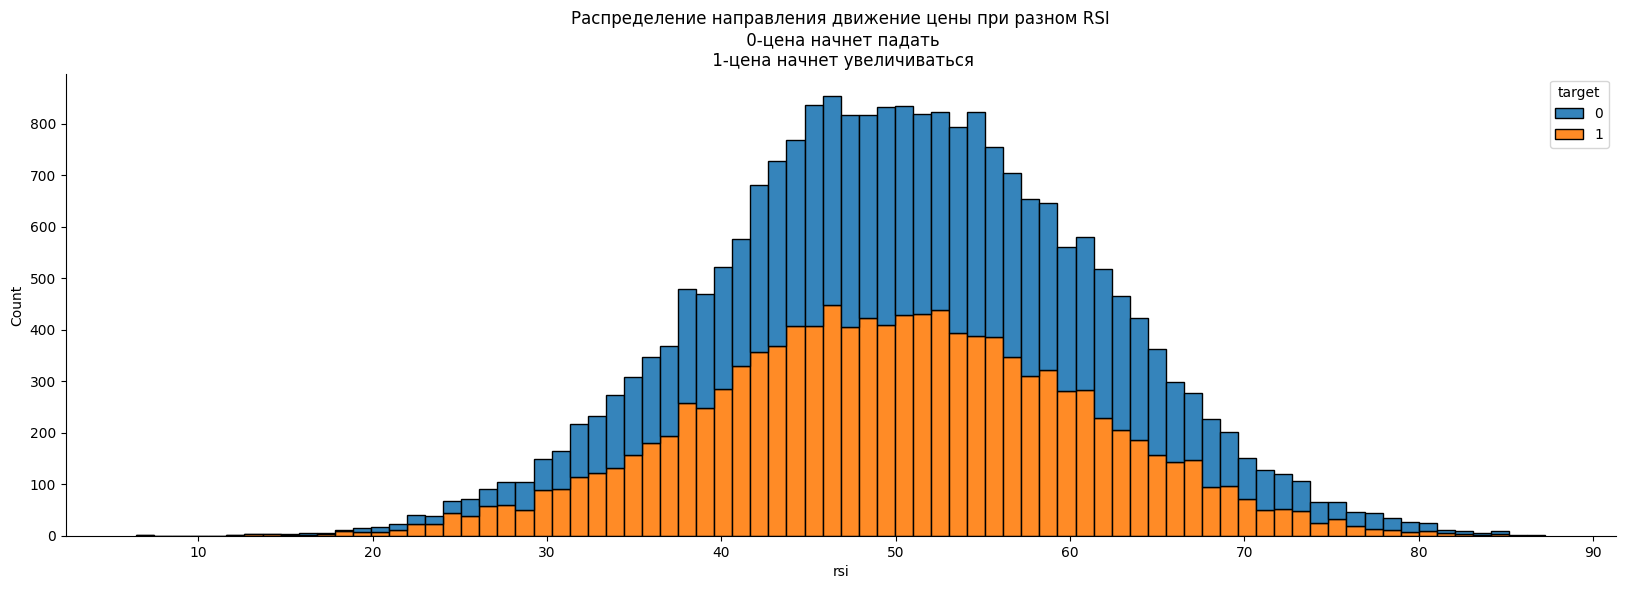

In [109]:
plt.subplots(figsize=(20,6));
sn.histplot(data=sol_data, x='rsi', hue='target', multiple='stack', alpha=0.9);
sn.despine(top=True, right=True)
plt.title('Распределение направления движение цены при разном RSI\n 0-цена начнет падать\n 1-цена начнет увеличиваться');

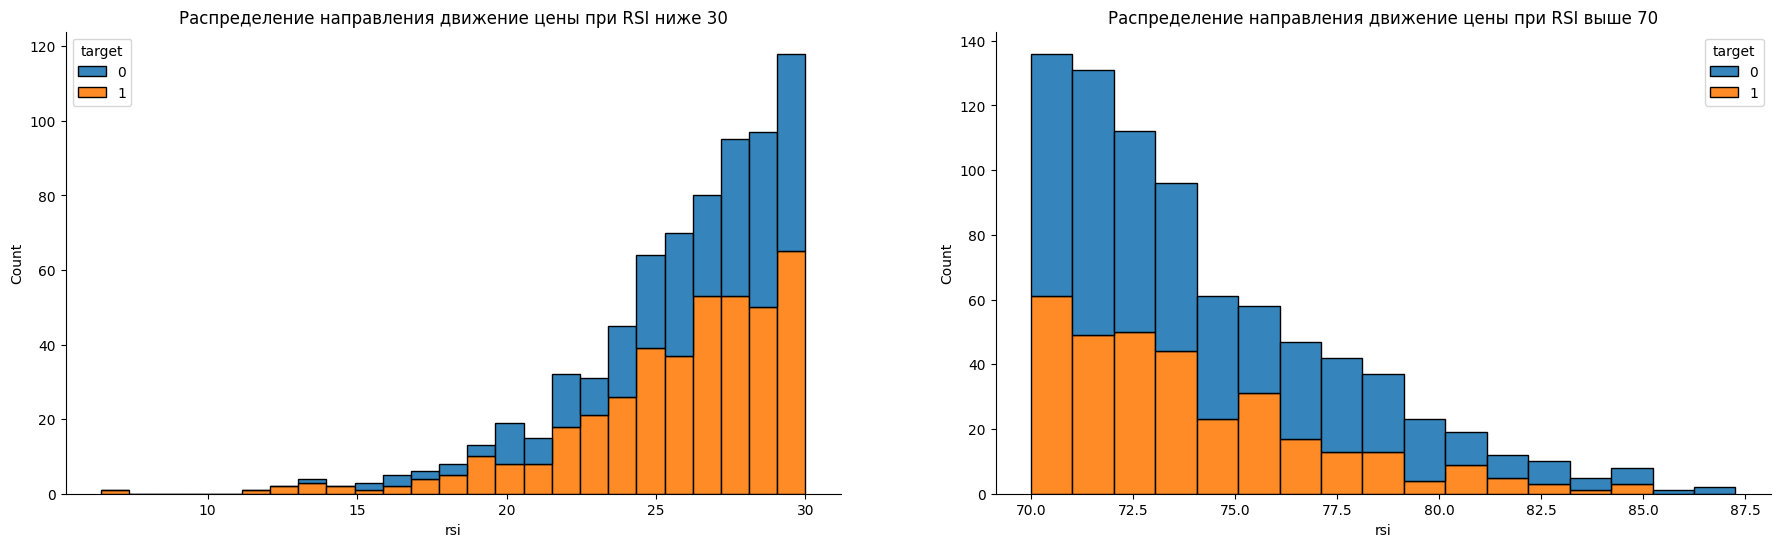

In [110]:
plt.figure(figsize=(22,6))
plt.subplot(121);
sn.histplot(data=sol_data[sol_data['rsi'] < 30], x='rsi', hue='target', multiple='stack', alpha=0.9);
plt.title('Распределение направления движение цены при RSI ниже 30');

plt.subplot(122);
sn.histplot(data=sol_data[sol_data['rsi'] > 70], x='rsi', hue='target', multiple='stack', alpha=0.9);
plt.title('Распределение направления движение цены при RSI выше 70');
sn.despine(top=True, right=True)


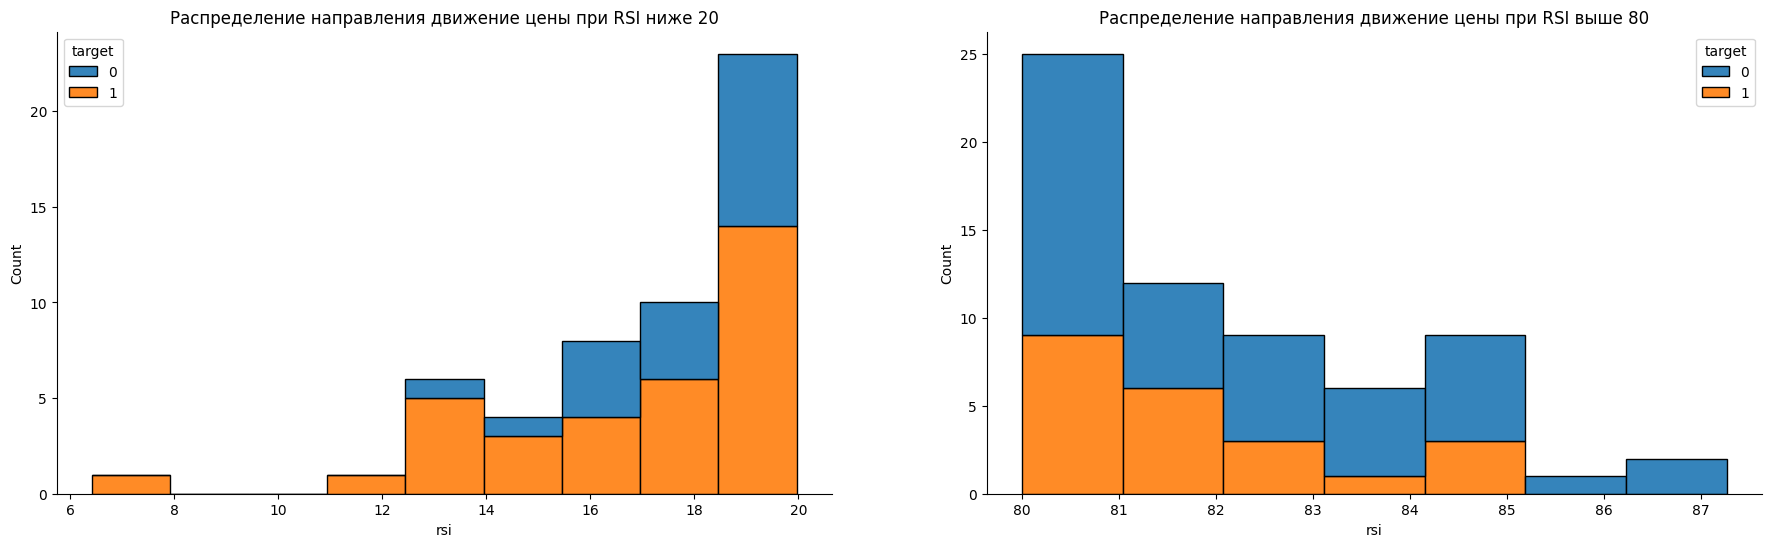

In [111]:
plt.figure(figsize=(22,6))
plt.subplot(121);
sn.histplot(data=sol_data[sol_data['rsi'] < 20], x='rsi', hue='target', multiple='stack', alpha=0.9);
sn.despine(top=True, right=True)
plt.title('Распределение направления движение цены при RSI ниже 20');

plt.subplot(122);
sn.histplot(data=sol_data[sol_data['rsi'] > 80], x='rsi', hue='target', multiple='stack', alpha=0.9);
sn.despine(top=True, right=True)
plt.title('Распределение направления движение цены при RSI выше 80');

**ВЫВОД ПОСЛЕ АНАЛИЗА RSI**

* **Разбор направлений движения цены после достижения каких либо критических значений RSI вообще не гарантирует предсказания направления цены**

### Пересечение линий MACD

**Для того, чтобы добавить признак пересечения линий MACD вверх\вниз и для простоты кода, чтобы не передавать в функцию весь датафрейм, а использовать быстрые стандартные функции, выполним работу в 2 шага. Шифт+эплай**

In [115]:
sol_data['macd_hist_prev'] = sol_data['macd_hist'].shift(1)

In [116]:
def macd_cross(data):
    if data['macd_hist_prev'] < 0 and data['macd_hist'] >= 0:
        return('пересечение вверх')
    if data['macd_hist_prev'] > 0 and data['macd_hist'] <= 0:
        return('пересечение вниз')
    else:
        return('пересечение отсутствует')

In [117]:
sol_data['is_macd_crossing'] = sol_data.apply(lambda row: macd_cross(row), axis=1)

In [118]:
sol_data['is_macd_crossing'].value_counts()

is_macd_crossing
пересечение отсутствует    20332
пересечение вниз            1164
пересечение вверх           1163
Name: count, dtype: int64

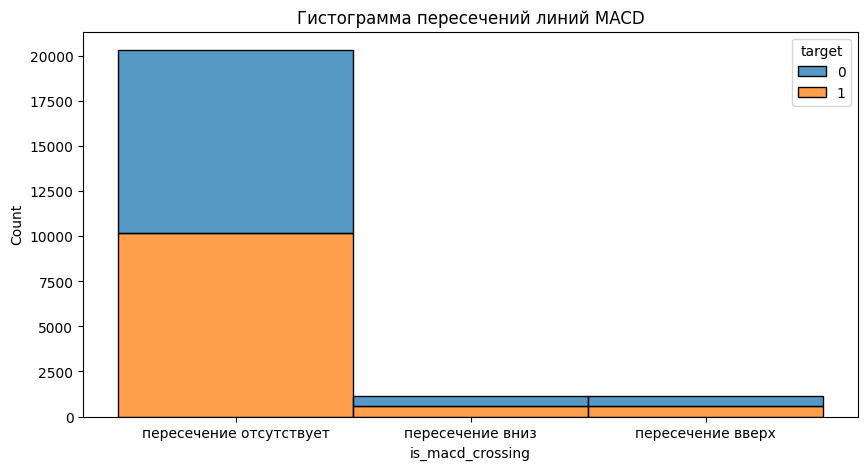

In [119]:
plt.subplots(figsize=(10,5));
sn.histplot(data=sol_data, x='is_macd_crossing', hue='target', multiple='stack');
plt.title('Гистограмма пересечений линий MACD');

In [120]:
sol_data[sol_data['is_macd_crossing']=='пересечение вверх']['target'].value_counts()

target
1    585
0    578
Name: count, dtype: int64

In [121]:
sol_data[sol_data['is_macd_crossing']=='пересечение вверх']['target'].value_counts(normalize=True)

target
1    0.503009
0    0.496991
Name: proportion, dtype: float64

**Грубо говоря отношение 50 на 50, сигналы макди просто подбрасывают монетку**

**Популярная страта торговли от пересечений линий MACD просто ни о чем**

In [124]:
sol_data[sol_data['is_macd_crossing']=='пересечение вниз']['target'].value_counts(normalize=True)

target
1    0.525773
0    0.474227
Name: proportion, dtype: float64

**При пересечении линий MACD вниз, сигнал чуть чаще отрабатывает наоборот....**

### Линии стохастика

**Так же добавим признак факта пересечения, хоть он и не основной. Вспомним, что основной наблюдаемый факт стохастика это пересечение медленной или медленной+быстрой (что лучше) уровней 20 и 80, в то время как пересечение линий стохастика аналогично линиям MACD на этих уровнях является дополнительным сигналом**

Для проверки факта пересечения добавим hist

In [129]:
def stoch_hist(row):
    return(row['stoch_k'] - row['stoch_d'])

In [130]:
sol_data['stoch_hist'] = sol_data.apply(lambda row: stoch_hist(row), axis=1)

**Теперь добавим проверку на пересечение**

In [132]:
sol_data['stoch_hist_prev'] = sol_data['stoch_hist'].shift(1)

In [133]:
def stoch_cross(data):
    if data['stoch_hist_prev'] < 0 and data['stoch_hist'] >= 0:
        return('пересечение вверх')
    if data['stoch_hist_prev'] > 0 and data['stoch_hist'] <= 0:
        return('пересечение вниз')
    else:
        return('пересечение отсутствует')

In [134]:
sol_data['is_stoch_crossing'] = sol_data.apply(lambda row: stoch_cross(row), axis=1)

In [135]:
sol_data.sample(5)

,open_price,high_price,low_price,close_price,trade_volume,next_close_price,next_high_price,target,target_high,ema_50,ema_100,ema_200,delta_ema_50,delta_ema_100,delta_ema_200,rsi,macd_line,signal_line,macd_hist,stoch_k,stoch_d,rsi_lvl,macd_hist_prev,is_macd_crossing,stoch_hist,stoch_hist_prev,is_stoch_crossing
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-18 05:30:00,199.438,202.451,199.289,202.178,145971.4,203.090,204.396,1,1,196.933933,193.826472,189.474396,5.244067,8.351528,12.703604,60.548003,0.411616,0.218975,0.192640,80.354123,62.867605,средние значения,-0.106128,пересечение вверх,17.486518,1.394885,пересечение отсутствует
2024-07-16 09:15:00,155.900,156.850,155.900,156.780,73527.4,155.930,156.850,0,0,156.574230,154.796507,151.483637,0.205770,1.983493,5.296363,47.866985,-0.350412,-0.186698,-0.163714,51.861042,33.995037,средние значения,-0.271295,пересечение отсутствует,17.866005,8.135950,пересечение отсутствует
2024-01-09 21:45:00,100.551,100.700,99.977,100.131,53647.5,100.158,100.425,1,0,100.298450,99.227839,97.616539,-0.167450,0.903161,2.514461,47.638667,-0.054562,-0.093051,0.038489,39.939940,53.207115,средние значения,0.059818,пересечение отсутствует,-13.267175,1.119155,пересечение вниз
2024-06-01 08:45:00,167.270,167.360,166.970,167.160,10261.9,167.200,167.290,1,0,166.874597,166.949505,167.315206,0.285403,0.210495,-0.155206,52.803311,0.069635,0.125228,-0.055593,29.310345,26.159004,средние значения,-0.058114,пересечение отсутствует,3.151341,12.969035,пересечение отсутствует
2024-04-15 07:15:00,146.350,148.500,145.910,148.100,129323.5,148.150,148.370,1,0,145.659318,144.249817,146.422321,2.440682,3.850183,1.677679,53.692769,0.031716,0.260479,-0.228762,63.112392,35.975237,средние значения,-0.326927,пересечение отсутствует,27.137155,-30.709520,пересечение вверх


**Для наглядности переставим столбы датафрейма тематически друг за другом**

In [137]:
sol_data.columns

Index(['open_price', 'high_price', 'low_price', 'close_price', 'trade_volume',
       'next_close_price', 'next_high_price', 'target', 'target_high',
       'ema_50', 'ema_100', 'ema_200', 'delta_ema_50', 'delta_ema_100',
       'delta_ema_200', 'rsi', 'macd_line', 'signal_line', 'macd_hist',
       'stoch_k', 'stoch_d', 'rsi_lvl', 'macd_hist_prev', 'is_macd_crossing',
       'stoch_hist', 'stoch_hist_prev', 'is_stoch_crossing'],
      dtype='object')

In [138]:
sol_data = sol_data.reindex(columns=['open_price', 'high_price', 'low_price', 'close_price', 'trade_volume','next_close_price', 'target',
                                     'ema_50', 'ema_100', 'ema_200',
                                     'delta_ema_50', 'delta_ema_100', 'delta_ema_200',
                                     'rsi', 'rsi_lvl',
                                     'macd_line','signal_line', 'macd_hist','macd_hist_prev', 'is_macd_crossing',
                                     'stoch_k', 'stoch_d','stoch_hist', 'stoch_hist_prev','is_stoch_crossing'])

**Добавим еще 2 признака:**

* Факт пересечения **медленной** линии стохастика уровня 80 вниз или уровня 20 вверх
* Факт пересечения **быстрой** линии стохастика уровня 80 вниз или уровня 20 вверх

In [140]:
sol_data['stoch_k_prev'] = sol_data['stoch_k'].shift(1)

In [141]:
sol_data['stoch_d_prev'] = sol_data['stoch_d'].shift(1)

In [142]:
def stoch_lvl(row, char):
    if char == 'k':
        if row['stoch_k_prev'] > 80 and row['stoch_k'] < 80:
            return('падение под 80')
        if row['stoch_k_prev'] < 20 and row['stoch_k'] > 20:
            return('рост выше 20')
        else:
            return('сигнал отсутствует')
    if char == 'd':
        if row['stoch_d_prev'] > 80 and row['stoch_d'] < 80:
            return('падение под 80')
        if row['stoch_d_prev'] < 20 and row['stoch_d'] > 20:
            return('рост выше 20')
        else:
            return('сигнал отсутствует')

In [143]:
sol_data['stoch_k_lvl'] = sol_data.apply(lambda row: stoch_lvl(row,'k'), axis=1)

In [144]:
sol_data['stoch_d_lvl'] = sol_data.apply(lambda row: stoch_lvl(row,'d'), axis=1)

In [145]:
sol_data.head(5)

,open_price,high_price,low_price,close_price,trade_volume,next_close_price,target,ema_50,ema_100,ema_200,delta_ema_50,delta_ema_100,delta_ema_200,rsi,rsi_lvl,macd_line,signal_line,macd_hist,macd_hist_prev,is_macd_crossing,stoch_k,stoch_d,stoch_hist,stoch_hist_prev,is_stoch_crossing,stoch_k_prev,stoch_d_prev,stoch_k_lvl,stoch_d_lvl
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-03 01:45:00,108.157,108.691,107.917,108.105,46407.3,107.527,0,109.619618,109.749292,107.926155,-1.514618,-1.644292,0.178845,45.212658,средние значения,-0.124168,-0.325735,0.201566,NaN,пересечение отсутствует,57.558887,59.457491,-1.898604,NaN,пересечение отсутствует,NaN,NaN,сигнал отсутствует,сигнал отсутствует
2024-01-03 02:00:00,108.105,108.182,107.276,107.527,50439.5,107.384,0,109.537555,109.705287,107.922183,-2.010555,-2.178287,-0.395183,41.274501,средние значения,-0.174177,-0.295423,0.121246,0.201566,пересечение отсутствует,32.805139,48.499436,-15.694296,-1.898604,пересечение отсутствует,57.558887,59.457491,сигнал отсутствует,сигнал отсутствует
2024-01-03 02:15:00,107.527,107.803,107.229,107.384,30843.9,107.000,0,109.453102,109.659320,107.916828,-2.069102,-2.275320,-0.532828,40.338354,средние значения,-0.220340,-0.280407,0.060067,0.121246,пересечение отсутствует,26.680942,39.014989,-12.334047,-15.694296,пересечение отсутствует,32.805139,48.499436,сигнал отсутствует,сигнал отсутствует
2024-01-03 02:30:00,107.384,107.405,106.800,107.000,62051.6,106.873,0,109.356901,109.606661,107.907706,-2.356901,-2.606661,-0.907706,37.855393,средние значения,-0.289481,-0.282221,-0.007259,0.060067,пересечение вниз,10.235546,23.240542,-13.004996,-12.334047,пересечение отсутствует,26.680942,39.014989,сигнал отсутствует,сигнал отсутствует
2024-01-03 02:45:00,107.000,107.031,106.112,106.873,140970.6,108.114,1,109.259494,109.552529,107.897410,-2.386494,-2.679529,-1.024410,37.043277,средние значения,-0.344245,-0.294626,-0.049619,-0.007259,пересечение отсутствует,25.502681,20.806390,4.696291,-13.004996,пересечение вверх,10.235546,23.240542,рост выше 20,сигнал отсутствует


Из-за функции шифт выше, получились пропуски в новых столбцах в 0 строке датафрейма. Удалим ее чтобы не было пропусков.

In [147]:
sol_data = sol_data.drop(sol_data.index[0])

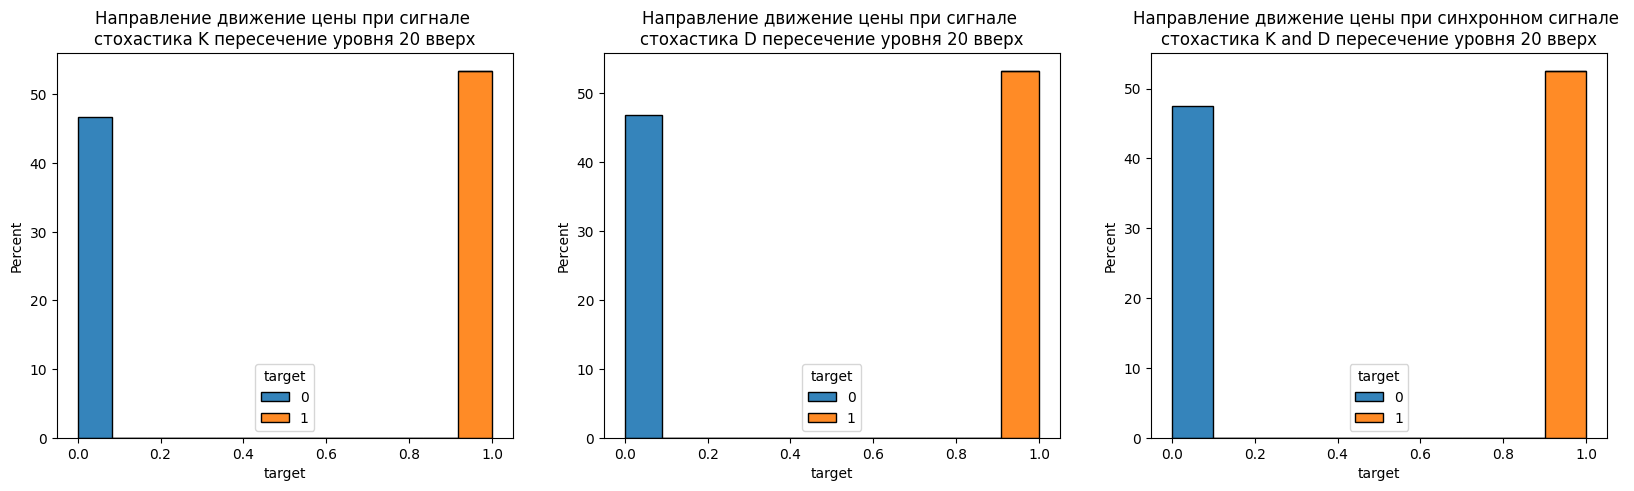

In [148]:
plt.figure(figsize=(20,5));

plt.subplot(131);
sn.histplot(data=sol_data[sol_data['stoch_k_lvl']=='рост выше 20'], x='target', hue='target', multiple='stack', alpha=0.9, stat='percent');
plt.title('Направление движение цены при сигнале \nстохастика K пересечение уровня 20 вверх');

plt.subplot(132);
sn.histplot(data=sol_data[sol_data['stoch_d_lvl']=='рост выше 20'], x='target', hue='target', multiple='stack', alpha=0.9, stat='percent');
plt.title('Направление движение цены при сигнале \nстохастика D пересечение уровня 20 вверх');

plt.subplot(133);
sn.histplot(data=sol_data[(sol_data['stoch_d_lvl']=='рост выше 20') & (sol_data['stoch_k_lvl']=='рост выше 20')], x='target', hue='target', multiple='stack', alpha=0.9, stat='percent');
plt.title('Направление движение цены при синхронном сигнале \nстохастика K and D пересечение уровня 20 вверх');

**Опять сигналы стохастика также не дают никаких определенных результатов**

In [150]:
sol_data.drop(['open_price','high_price','low_price','close_price','trade_volume','ema_50','ema_100','ema_200','delta_ema_50','delta_ema_100','delta_ema_200'],axis=1).tail(14)

,next_close_price,target,rsi,rsi_lvl,macd_line,signal_line,macd_hist,macd_hist_prev,is_macd_crossing,stoch_k,stoch_d,stoch_hist,stoch_hist_prev,is_stoch_crossing,stoch_k_prev,stoch_d_prev,stoch_k_lvl,stoch_d_lvl
date_time,,,,,,,,,,,,,,,,,,
2024-08-26 00:45:00,161.84,1,67.291635,средние значения,0.435096,0.187441,0.247655,0.179777,пересечение отсутствует,92.281879,81.680167,10.601713,-2.528736,пересечение вверх,75.517241,78.045977,сигнал отсутствует,сигнал отсутствует
2024-08-26 01:00:00,160.74,0,70.534707,перекупленность_70,0.579642,0.265881,0.313761,0.247655,пересечение отсутствует,98.235294,88.678138,9.557156,10.601713,пересечение отсутствует,92.281879,81.680167,сигнал отсутствует,сигнал отсутствует
2024-08-26 01:15:00,160.35,0,58.824121,средние значения,0.543040,0.321313,0.221727,0.313761,пересечение отсутствует,65.882353,85.466509,-19.584156,9.557156,пересечение вниз,98.235294,88.678138,падение под 80,сигнал отсутствует
2024-08-26 01:30:00,160.55,1,55.317454,средние значения,0.460994,0.349249,0.111745,0.221727,пересечение отсутствует,54.411765,72.843137,-18.431373,-19.584156,пересечение отсутствует,65.882353,85.466509,сигнал отсутствует,падение под 80
2024-08-26 01:45:00,161.10,1,56.741616,средние значения,0.415110,0.362421,0.052689,0.111745,пересечение отсутствует,60.294118,60.196078,0.098039,-18.431373,пересечение вверх,54.411765,72.843137,сигнал отсутствует,сигнал отсутствует
2024-08-26 02:00:00,160.20,0,60.472708,средние значения,0.434249,0.376787,0.057462,0.052689,пересечение отсутствует,76.470588,63.725490,12.745098,0.098039,пересечение отсутствует,60.294118,60.196078,сигнал отсутствует,сигнал отсутствует
2024-08-26 02:15:00,159.14,0,52.493884,средние значения,0.336759,0.368781,-0.032022,0.057462,пересечение вниз,50.000000,62.254902,-12.254902,12.745098,пересечение вниз,76.470588,63.725490,сигнал отсутствует,сигнал отсутствует
2024-08-26 02:30:00,158.86,0,44.968392,средние значения,0.143266,0.323678,-0.180412,-0.032022,пересечение отсутствует,18.823529,48.431373,-29.607843,-12.254902,пересечение отсутствует,50.000000,62.254902,сигнал отсутствует,сигнал отсутствует
2024-08-26 02:45:00,158.79,0,43.206372,средние значения,-0.025156,0.253911,-0.279067,-0.180412,пересечение отсутствует,14.124294,27.649274,-13.524981,-29.607843,пересечение отсутствует,18.823529,48.431373,сигнал отсутствует,сигнал отсутствует


In [151]:
sol_data.to_csv('H:\sol_data.csv', index=True)

**------------------------------------------**

**------------------------------------------**

## Подготовка данных для ML

**Изучим корреляцию**

In [156]:
phik_col = sol_data.drop(['open_price','high_price','low_price','close_price','trade_volume', 'next_close_price'], axis=1)

In [157]:
phik_col_interval = phik_col.select_dtypes(include=['number']).columns

In [158]:
phik_col_interval

Index(['target', 'ema_50', 'ema_100', 'ema_200', 'delta_ema_50',
       'delta_ema_100', 'delta_ema_200', 'rsi', 'macd_line', 'signal_line',
       'macd_hist', 'macd_hist_prev', 'stoch_k', 'stoch_d', 'stoch_hist',
       'stoch_hist_prev', 'stoch_k_prev', 'stoch_d_prev'],
      dtype='object')

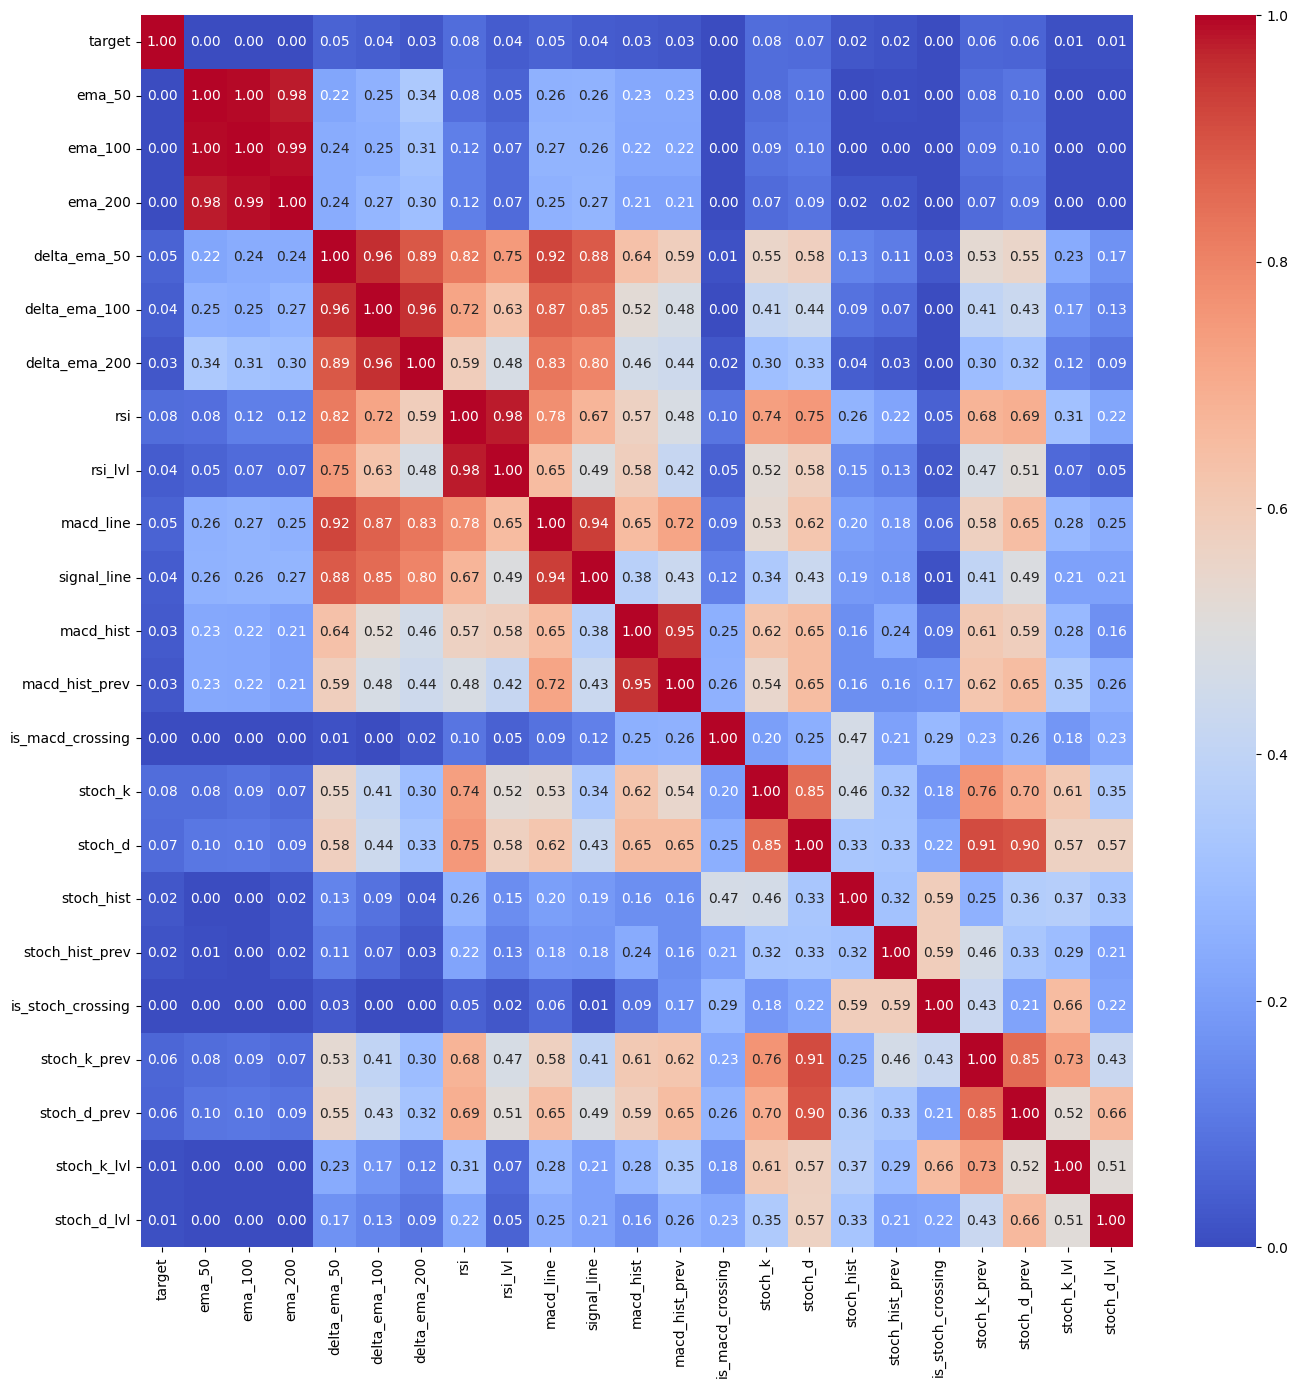

In [159]:
plt.subplots(figsize=(16, 16));
sn.heatmap(phik_col.phik_matrix(interval_cols=phik_col_interval),
           annot=True,
           annot_kws={"size": 10},
           fmt='.2f',
           cmap='coolwarm');

**Наблюдаем высочайшую (что не удивительно) мультиколинеарность между всеми признаками вида ema_ и delta_ema_, для обучения моделей уберем их из обучающего датасета**


**Спойлер:** обучение проводилось и с полным сетом и с очищенным от мультиколинеарности, логическая регерессия чуть-чуть подтянулась, а бустовые модели показали теже результаты

In [161]:
sol_data.isna().sum()

open_price           0
high_price           0
low_price            0
close_price          0
trade_volume         0
next_close_price     0
target               0
ema_50               0
ema_100              0
ema_200              0
delta_ema_50         0
delta_ema_100        0
delta_ema_200        0
rsi                  0
rsi_lvl              0
macd_line            0
signal_line          0
macd_hist            0
macd_hist_prev       0
is_macd_crossing     0
stoch_k              0
stoch_d              0
stoch_hist           0
stoch_hist_prev      0
is_stoch_crossing    0
stoch_k_prev         0
stoch_d_prev         0
stoch_k_lvl          0
stoch_d_lvl          0
dtype: int64

В датасете появились пропуски связанные с тем, что для некоторых столбоцов перед появлением в них первой информации, требовался сбор с N-го количества предшествующих строк. Для того чтобы в данных не было пропусков, мы просто удалим первые 200 строк, что уберет все пропуски, и не потребуется заполнять их недействительными данными.

In [163]:
sol_data = sol_data.drop(sol_data.index[:200])

In [164]:
sol_data.isna().sum()

open_price           0
high_price           0
low_price            0
close_price          0
trade_volume         0
next_close_price     0
target               0
ema_50               0
ema_100              0
ema_200              0
delta_ema_50         0
delta_ema_100        0
delta_ema_200        0
rsi                  0
rsi_lvl              0
macd_line            0
signal_line          0
macd_hist            0
macd_hist_prev       0
is_macd_crossing     0
stoch_k              0
stoch_d              0
stoch_hist           0
stoch_hist_prev      0
is_stoch_crossing    0
stoch_k_prev         0
stoch_d_prev         0
stoch_k_lvl          0
stoch_d_lvl          0
dtype: int64

### Выбор признаков участвующих в модели

In [166]:
sol_data.columns

Index(['open_price', 'high_price', 'low_price', 'close_price', 'trade_volume',
       'next_close_price', 'target', 'ema_50', 'ema_100', 'ema_200',
       'delta_ema_50', 'delta_ema_100', 'delta_ema_200', 'rsi', 'rsi_lvl',
       'macd_line', 'signal_line', 'macd_hist', 'macd_hist_prev',
       'is_macd_crossing', 'stoch_k', 'stoch_d', 'stoch_hist',
       'stoch_hist_prev', 'is_stoch_crossing', 'stoch_k_prev', 'stoch_d_prev',
       'stoch_k_lvl', 'stoch_d_lvl'],
      dtype='object')

In [167]:
model_columns = ['target',
        'rsi', 'rsi_lvl',
       'macd_line', 'signal_line', 'macd_hist', 'macd_hist_prev','is_macd_crossing',
        'stoch_k', 'stoch_d', 'stoch_hist','stoch_hist_prev',
        'is_stoch_crossing', 'stoch_k_prev', 'stoch_d_prev','stoch_k_lvl', 'stoch_d_lvl']

In [168]:
interval_columns = ['rsi','macd_line', 'signal_line', 'macd_hist', 'macd_hist_prev',
                    'stoch_k', 'stoch_d', 'stoch_hist','stoch_hist_prev', 'stoch_k_prev', 'stoch_d_prev']

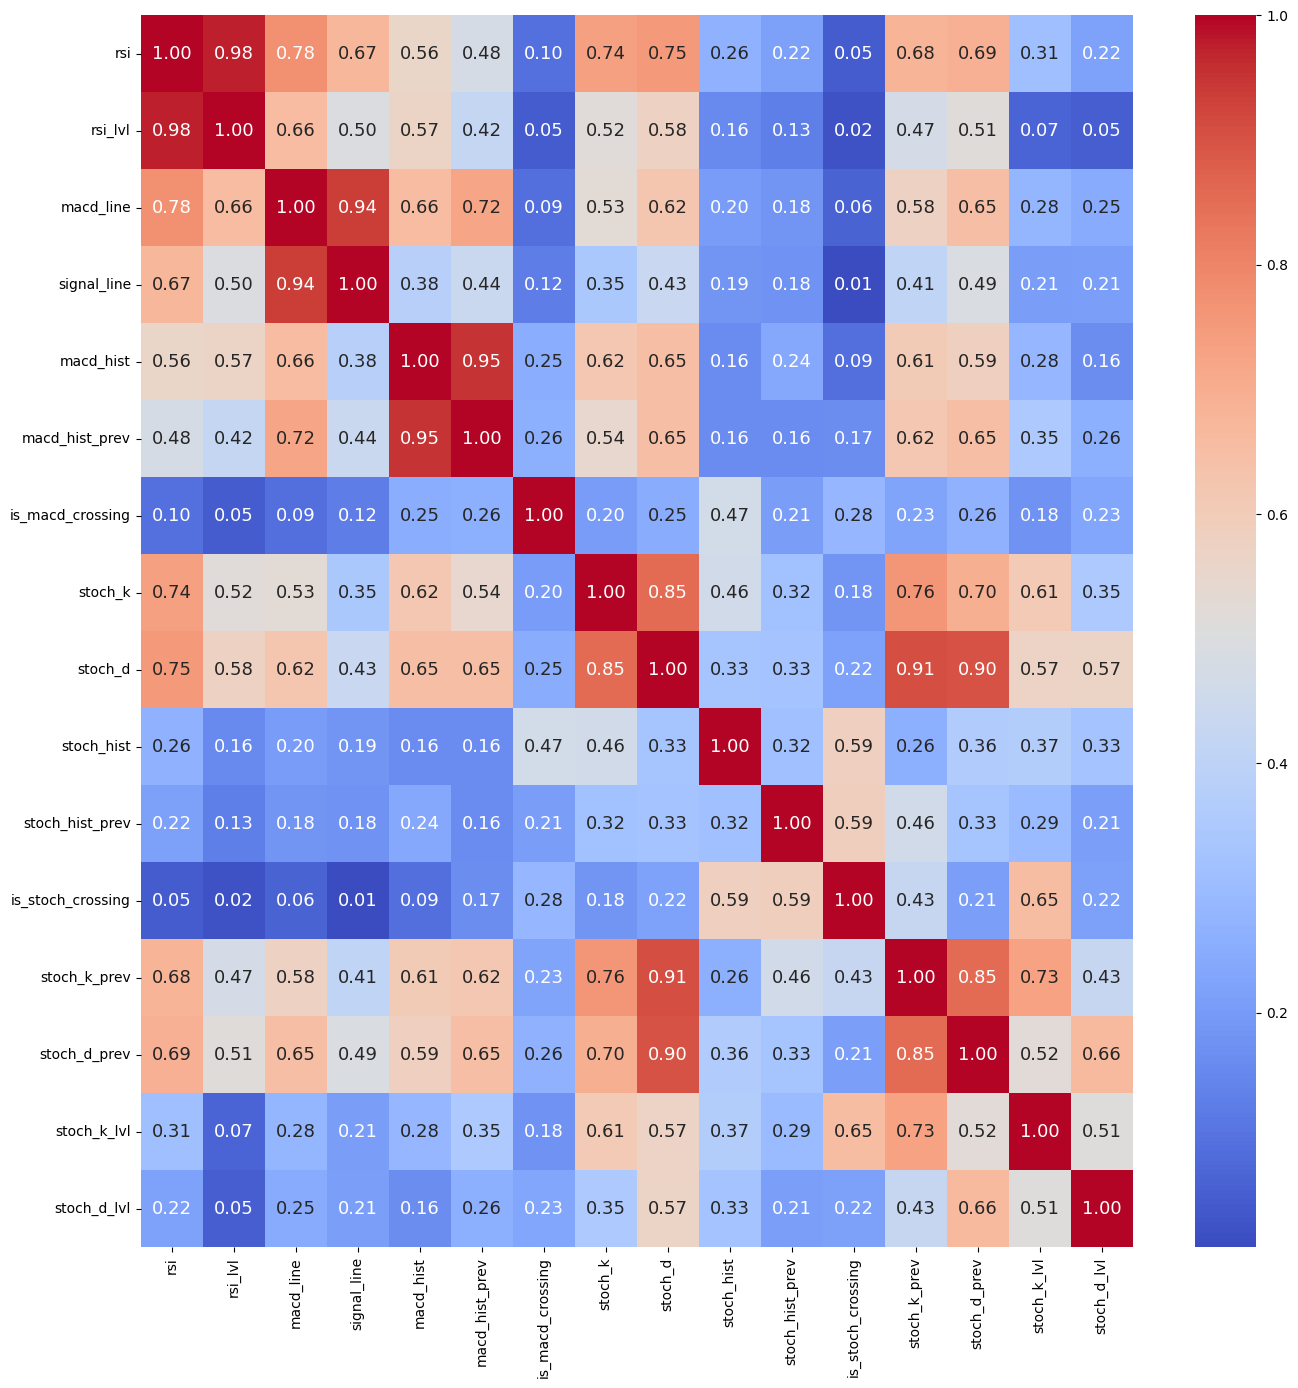

In [169]:
plt.subplots(figsize=(16, 16));
sn.heatmap(sol_data[model_columns].drop('target', axis=1).phik_matrix(interval_cols=sol_data[interval_columns]),
           annot=True,
           annot_kws={"size": 13},
           fmt='.2f',
           cmap='coolwarm');

In [170]:
train, test = train_test_split(sol_data[model_columns], shuffle=False, test_size=0.1)

In [171]:
X_train = train.drop('target', axis=1)

In [172]:
y_train = train['target']

In [173]:
X_test = test.drop('target', axis=1)

In [174]:
y_test = test['target']

In [175]:
tscv = TimeSeriesSplit(n_splits=2)

*stop

## Обучение моделей

### LogisticRegression

In [179]:
num_columns = X_train.select_dtypes(include=['number']).columns

In [180]:
ohe_columns = X_train.select_dtypes(exclude=['number']).columns

In [181]:
num_columns

Index(['rsi', 'macd_line', 'signal_line', 'macd_hist', 'macd_hist_prev',
       'stoch_k', 'stoch_d', 'stoch_hist', 'stoch_hist_prev', 'stoch_k_prev',
       'stoch_d_prev'],
      dtype='object')

In [182]:
ohe_columns

Index(['rsi_lvl', 'is_macd_crossing', 'is_stoch_crossing', 'stoch_k_lvl',
       'stoch_d_lvl'],
      dtype='object')

In [183]:
ohe_pipe = Pipeline(
    [
        (
            'ohe', OneHotEncoder(handle_unknown='ignore', drop='first')
        )
    ]
)

In [184]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [185]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', None)
    ]
) 

In [186]:
param_grid = [
    {
        'models': [LogisticRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [187]:
lr_gs = GridSearchCV(
    pipe_final, 
    param_grid,
    cv=tscv,
    scoring = 'accuracy',
    n_jobs=-1,
    verbose=2
)

In [188]:
lr_gs.fit(X_train, y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         Index(['rsi_lvl', 'is_macd_crossing', 'is_stoch_crossing', 'stoch_k_lvl',
       'stoch_d_lvl...
                                                                         StandardScaler(),
                                                                         Index(['rsi', 'macd_line', 'signal_line', 'macd_hist', 'macd_hist_prev',
       'stoch_k', 'stoch_d', 'stoch_hist', 'stoch_hist_prev', 'stoch_k_prev',
       'stoch_d_prev'],
      dtype='object'))])),
                                       ('models', None)]),
             n_jobs=-1,
             param_grid=[{'models': [LogisticRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='accuracy', verbose=2)

In [189]:
lr_score = lr_gs.best_score_

In [190]:
print ('Метрика лучшей модели на кроссвалидации:', lr_score)

Метрика лучшей модели на кроссвалидации: 0.5214487160457177


In [191]:
lr_prediction = lr_gs.best_estimator_.predict(X_test)

In [192]:
lr_accuracy = accuracy_score(y_test, lr_prediction)

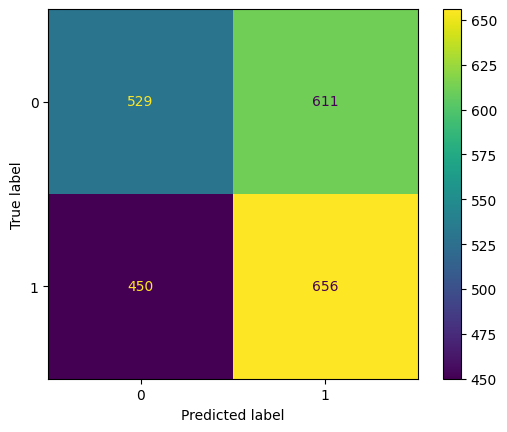

In [193]:
ConfusionMatrixDisplay.from_estimator(lr_gs.best_estimator_, X_test, y_test);

In [194]:
print("Accuracy Score:", lr_accuracy)

Accuracy Score: 0.5276046304541407


### Catboost

In [196]:
model = CatBoostClassifier(max_depth=4, random_state=RANDOM_STATE, verbose=False)

In [197]:
cat_features = X_train.select_dtypes(exclude=['number']).columns.to_list()

In [198]:
cat_features

['rsi_lvl',
 'is_macd_crossing',
 'is_stoch_crossing',
 'stoch_k_lvl',
 'stoch_d_lvl']

In [199]:
model.set_params(cat_features = cat_features)

In [200]:
param_grid_cat = [

    {
        'learning_rate':[0.1, 0.3]
    }
]

In [201]:
catboost_gs = GridSearchCV(
    model, 
    param_grid_cat,
    cv=tscv,
    scoring = 'accuracy',  
    n_jobs=-1,
    verbose=2
)

In [202]:
catboost_gs.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=<catboost.core.CatBoostClassifier object at 0x000002B6291B8910>,
             n_jobs=-1, param_grid=[{'learning_rate': [0.1, 0.3]}],
             scoring='accuracy', verbose=2)

In [203]:
catboost_score = round((catboost_gs.best_score_), 4)

In [204]:
print(f'Метрика на кросс-валидационной выборке: {catboost_score}')

Метрика на кросс-валидационной выборке: 0.5117


In [205]:
catboost_prediction = catboost_gs.best_estimator_.predict(X_test)

In [206]:
catboost_accuracy = accuracy_score(y_test, catboost_prediction)

In [207]:
print("Accuracy Score:", catboost_accuracy)

Accuracy Score: 0.5106856634016028


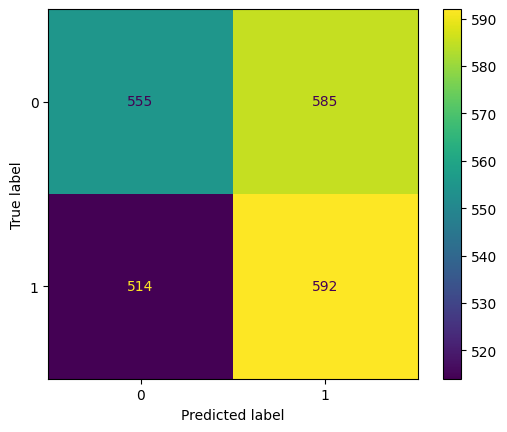

In [208]:
ConfusionMatrixDisplay.from_estimator(catboost_gs.best_estimator_, X_test, y_test);

### LGB

In [210]:
model_lgb = lgb.LGBMClassifier(random_state=RANDOM_STATE,  force_col_wise=True)

In [211]:
param_grid_gbm = {
 'learning_rate': [0.1, 0.05],
 'n_estimators': [150 ,100],
 'max_depth': [5,7],
 'num_leaves':[3,5,7]
}

In [212]:
lgbm_gs = GridSearchCV(model_lgb, param_grid_gbm, cv=tscv, scoring='accuracy', n_jobs=-1, verbose=2)

In [213]:
X_train[cat_features] = X_train[cat_features].astype('category')

In [214]:
X_test[cat_features] = X_test[cat_features].astype('category')

In [215]:
lgbm_gs.fit(X_train, y_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[LightGBM] [Info] Number of positive: 10179, number of negative: 10033
[LightGBM] [Info] Total Bins 2826
[LightGBM] [Info] Number of data points in the train set: 20212, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503612 -> initscore=0.014447
[LightGBM] [Info] Start training from score 0.014447


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=LGBMClassifier(force_col_wise=True, random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05], 'max_depth': [5, 7],
                         'n_estimators': [150, 100], 'num_leaves': [3, 5, 7]},
             scoring='accuracy', verbose=2)

In [216]:
lgbm_score = round((lgbm_gs.best_score_),4)

In [217]:
print(f'Метрика accuracy_score для лучшей модели c градиентным бустингом на кроссвалидации равна {lgbm_score}')

Метрика accuracy_score для лучшей модели c градиентным бустингом на кроссвалидации равна 0.5196


In [218]:
lgbm_prediction = lgbm_gs.best_estimator_.predict(X_test)

In [219]:
lgbm_accuracy = accuracy_score(y_test, lgbm_prediction)

In [220]:
print("Accuracy Score:", lgbm_accuracy)

Accuracy Score: 0.5120213713268033


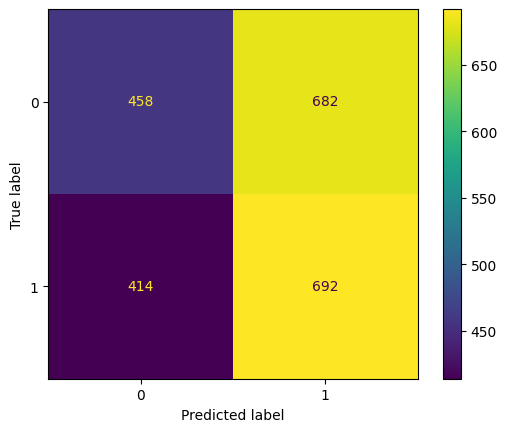

In [221]:
ConfusionMatrixDisplay.from_estimator(lgbm_gs.best_estimator_, X_test, y_test);

## Оценка и анализ результатов моделей

### Суммирование оценок моделей

In [224]:
cross_val_scores = lr_score, catboost_score, lgbm_score
test_scores = lr_accuracy, catboost_accuracy, lgbm_accuracy

In [225]:
models = ['Logistic_regression','Catboost','LGBM']

In [226]:
results_df = pd.DataFrame({
    'Models': models,
    'Cross_val_score': cross_val_scores,
    'Test_score': test_scores
                          })

In [227]:
results_df = results_df.sort_values('Cross_val_score', ascending=False)

In [228]:
results_df = results_df.set_index('Models')

In [229]:
results_df

,Cross_val_score,Test_score
Models,,
Logistic_regression,0.521449,0.527605
LGBM,0.519600,0.512021
Catboost,0.511700,0.510686


#### Матрицы ошибок

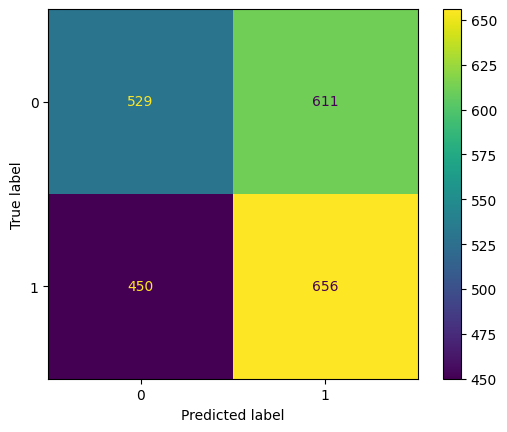

In [231]:
ConfusionMatrixDisplay.from_estimator(lr_gs.best_estimator_, X_test, y_test);

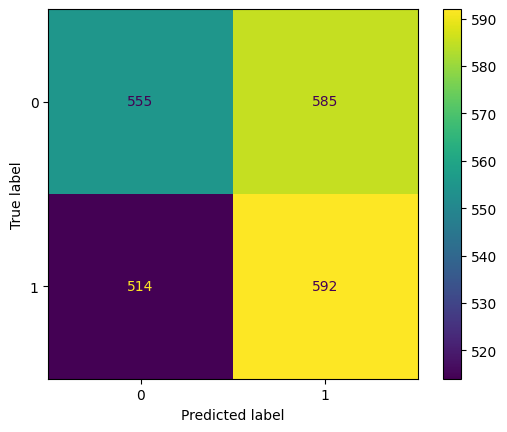

In [232]:
ConfusionMatrixDisplay.from_estimator(catboost_gs.best_estimator_, X_test, y_test);

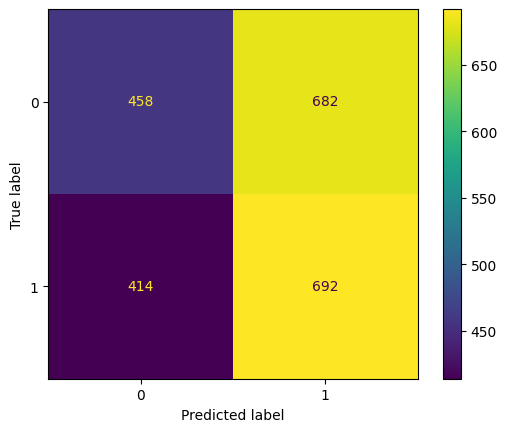

In [233]:
ConfusionMatrixDisplay.from_estimator(lgbm_gs.best_estimator_, X_test, y_test);

## Анализ важности признаков моделей

### Логистическая регрессия

In [236]:
lr_shap = lr_gs.best_estimator_.named_steps['preprocessor'].transform(X_test)

In [237]:
explainer = shap.LinearExplainer(lr_gs.best_estimator_['models'], lr_shap)

In [238]:
ohe_names = lr_gs.best_estimator_.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()

In [239]:
num_names = lr_gs.best_estimator_.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out()

In [240]:
feature_names = np.concatenate([ohe_names,num_names])

In [241]:
explainer.feature_names = feature_names

In [242]:
shap_values = explainer(lr_shap)

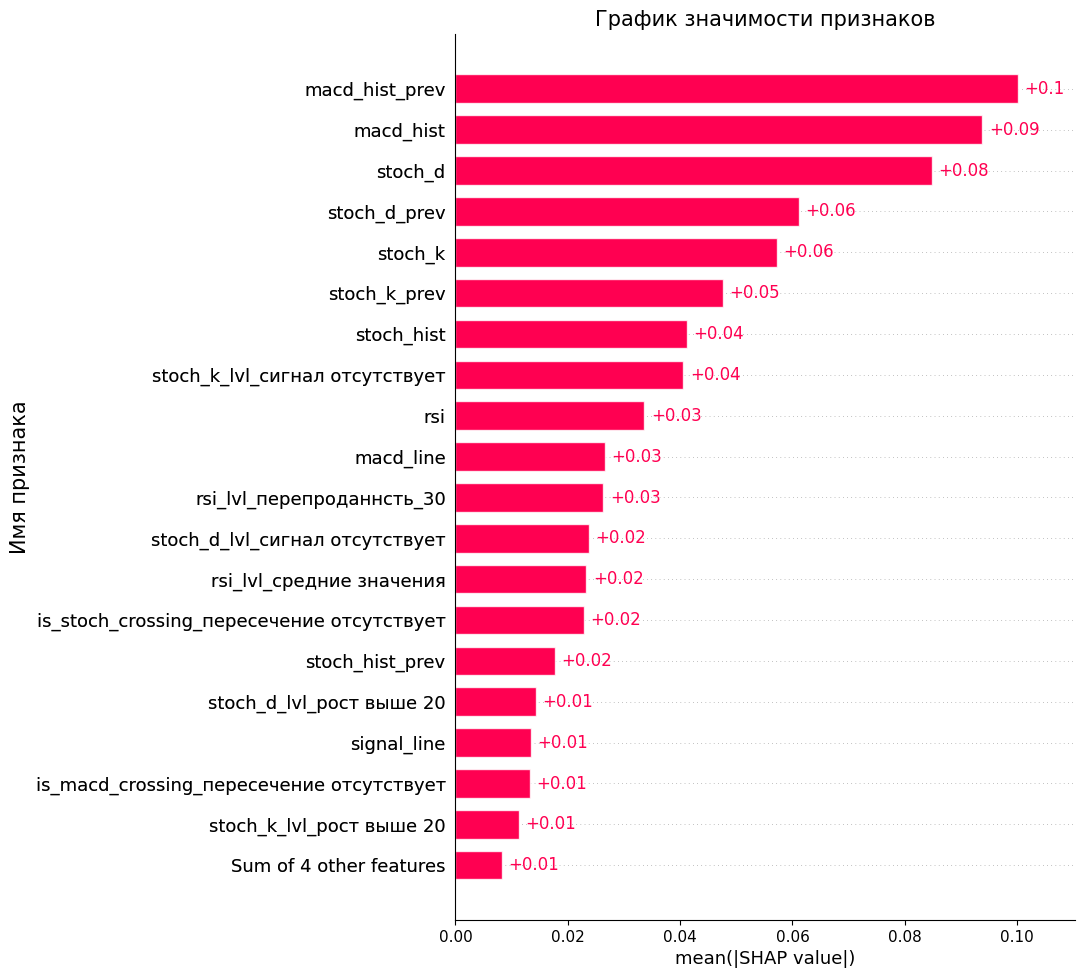

In [243]:
plt.subplots(figsize=(12, 6))
plt.title(label='График значимости признаков' , fontsize=15)
plt.xlabel('shap_value или значимость', fontsize=15)
plt.ylabel('Имя признака', fontsize=15)
shap.plots.bar(shap_values, max_display=20)
plt.show()

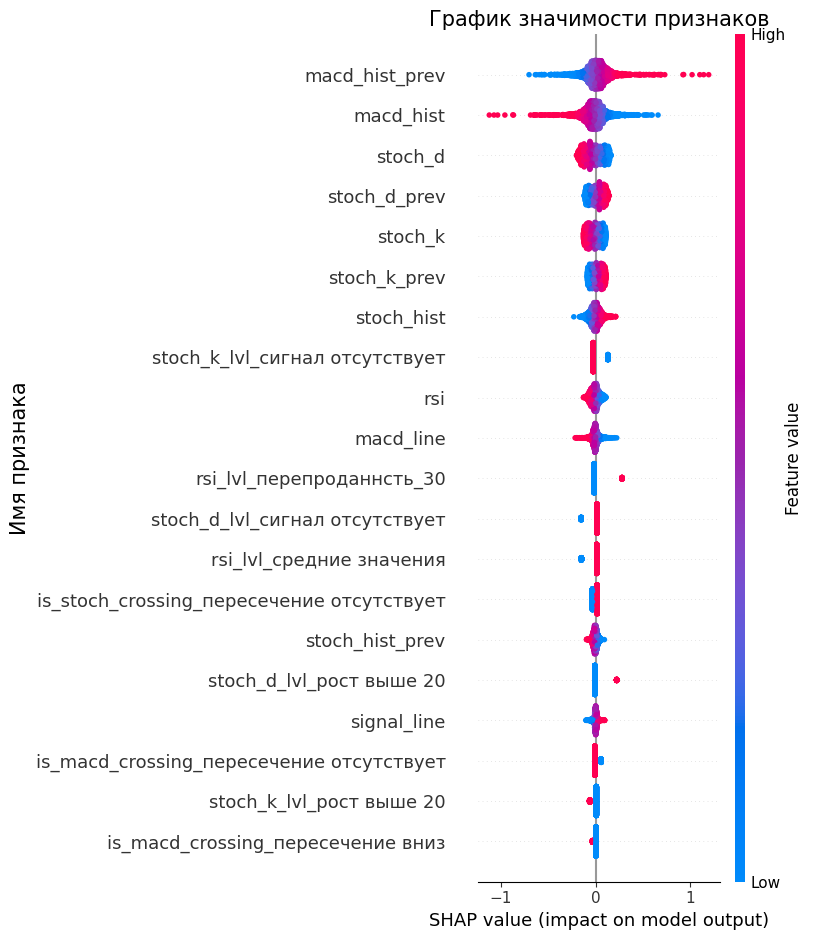

In [244]:
plt.subplots(figsize=(10, 10))
plt.title(label='График значимости признаков' , fontsize=15)
plt.xlabel('shap_value или значимость', fontsize=15)
plt.ylabel('Имя признака', fontsize=15)
shap.summary_plot(shap_values, max_display=20)
plt.show()

### Анализ важности признаков catboost

In [246]:
importances = catboost_gs.best_estimator_.get_feature_importance()

In [247]:
importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

In [248]:
importances_df = importances_df.sort_values('Importance', ascending=False)

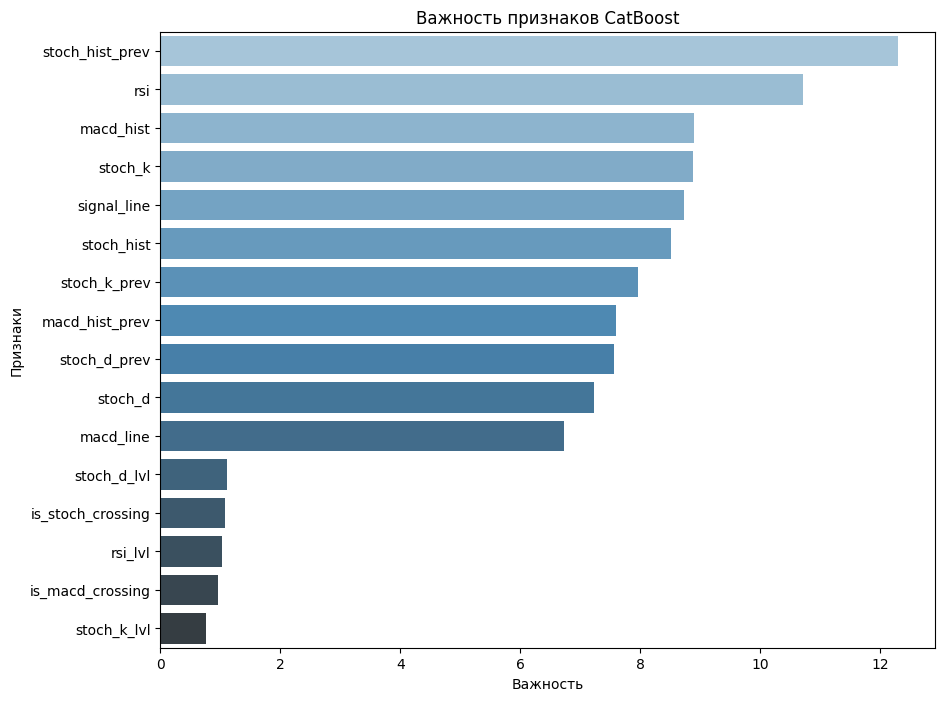

In [249]:
plt.figure(figsize=(10, 8))
sn.barplot(x='Importance', y='Feature', data=importances_df, palette='Blues_d', hue='Feature')
plt.title('Важность признаков CatBoost')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.show()

### Анализ важности признаков LGBM

In [251]:
importances_lgbm = lgbm_gs.best_estimator_.feature_importances_

In [252]:
importances_df_lgbm = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances_lgbm})

In [253]:
importances_df_lgbm = importances_df_lgbm.sort_values('Importance', ascending=False)

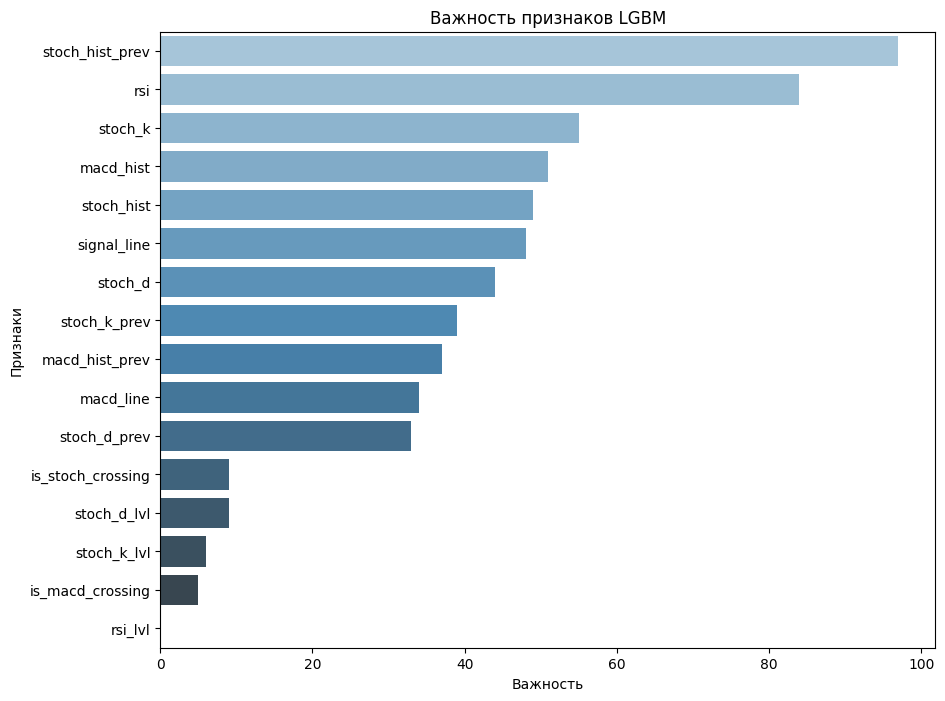

In [254]:
plt.figure(figsize=(10, 8))
sn.barplot(x='Importance', y='Feature', data=importances_df_lgbm, palette='Blues_d', hue='Feature')
plt.title('Важность признаков LGBM')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.show()

In [255]:
explainer_lgbm = shap.Explainer(lgbm_gs.best_estimator_)

In [256]:
shap_values = explainer_lgbm(X_train)

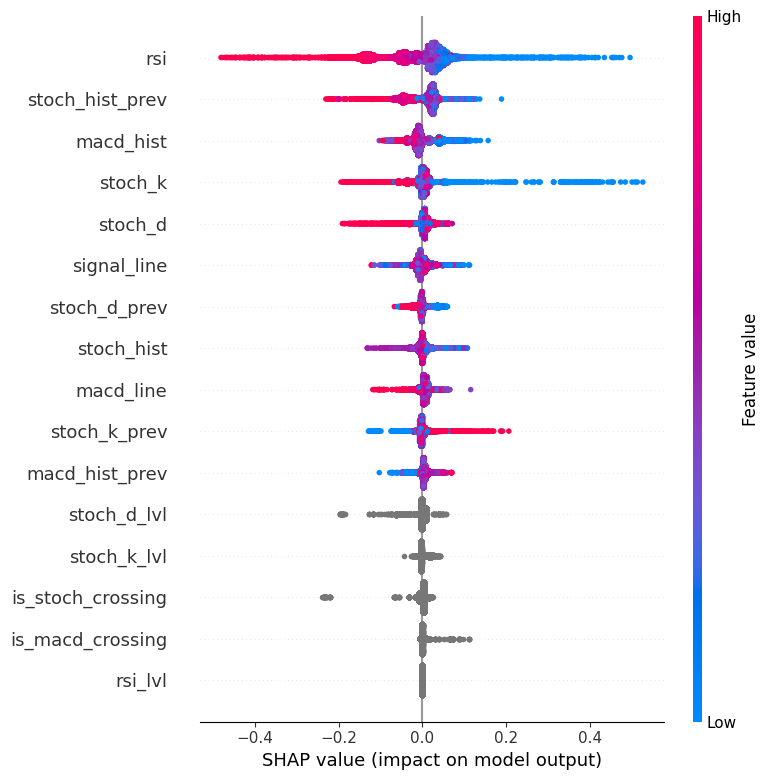

In [257]:
shap.summary_plot(shap_values, X_train)

### Промежуточной вывод по признакам

In [259]:
results_df

,Cross_val_score,Test_score
Models,,
Logistic_regression,0.521449,0.527605
LGBM,0.519600,0.512021
Catboost,0.511700,0.510686


* **Все модели показали примерно равные метрики, плохие метрики, на уровне случайности**
*  **"бустовые модели" в вывели в топ по полезности одни и теже признакми**
*  **Все 3 модели часть признаков посчитали неинформатвными**
      * rsi_lvl, stock_k_lvl, stoch_d_lvl, is_stoch_crossing, is_macd_crossing etc.
      * **И все это категоральные признаки**


**Для попытки увеличения метрик, удалим из обучения метрики, которые признаны неинформативными, чтобы они не "перетягивали на себя одеяло" весов с более полезных метрик**

## Повторное обучение моделей с удаленными неинформативными входящими признаками

In [263]:
model_columns = ['target',
                 'rsi',
                 'macd_line', 'signal_line', 'macd_hist', 'macd_hist_prev',
                 'stoch_k', 'stoch_d', 'stoch_hist','stoch_hist_prev', 'stoch_k_prev', 'stoch_d_prev']

In [264]:
train_2, test_2 = train_test_split(sol_data[model_columns], shuffle=False, test_size=0.1)
X_train_2 = train_2.drop('target', axis=1)
y_train_2 = train_2['target']
X_test_2 = test_2.drop('target', axis=1)
y_test_2 = test_2['target']

### Logistic Regression

In [266]:
num_columns = X_train_2.select_dtypes(include=['number']).columns
ohe_columns = X_train_2.select_dtypes(exclude=['number']).columns

In [267]:
num_columns

Index(['rsi', 'macd_line', 'signal_line', 'macd_hist', 'macd_hist_prev',
       'stoch_k', 'stoch_d', 'stoch_hist', 'stoch_hist_prev', 'stoch_k_prev',
       'stoch_d_prev'],
      dtype='object')

In [268]:
ohe_columns

Index([], dtype='object')

In [269]:
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [270]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', None)
    ]
) 

In [271]:
param_grid = [
    {
        'models': [LogisticRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [272]:
lr_gs_2 = GridSearchCV(
    pipe_final, 
    param_grid,
    cv=tscv,
    scoring = 'accuracy',
    n_jobs=-1,
    verbose=2
)

In [273]:
lr_gs_2.fit(X_train_2, y_train_2)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['rsi', 'macd_line', 'signal_line', 'macd_hist', 'macd_hist_prev',
       'stoch_k', 'stoch_d', 'stoch_hist', 'stoch_hist_prev', 'stoch_k_prev',
       'stoch_d_prev'],
      dtype='object'))])),
                                       ('models', None)]),
             n_jobs=-1,
             param_grid=[{'models': [LogisticRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='accuracy', verbose=2)

In [274]:
lr_score_2 = lr_gs_2.best_score_

In [275]:
print ('Метрика лучшей модели на кроссвалидации:', lr_score_2)

Метрика лучшей модели на кроссвалидации: 0.518108950571471


In [276]:
print ('Метрика ПРЕДЫДУЩЕЙ модели линейной регресии на кроссвалидации:', lr_score)

Метрика ПРЕДЫДУЩЕЙ модели линейной регресии на кроссвалидации: 0.5214487160457177


In [277]:
lr_2_prediction = lr_gs_2.best_estimator_.predict(X_test_2)
lr_2_accuracy = accuracy_score(y_test_2, lr_2_prediction)

In [278]:
print("Accuracy Score обновленной LR:", lr_2_accuracy)

Accuracy Score обновленной LR: 0.5155832591273375


In [279]:
print("Accuracy Score предыдущей LR:", lr_accuracy)

Accuracy Score предыдущей LR: 0.5276046304541407


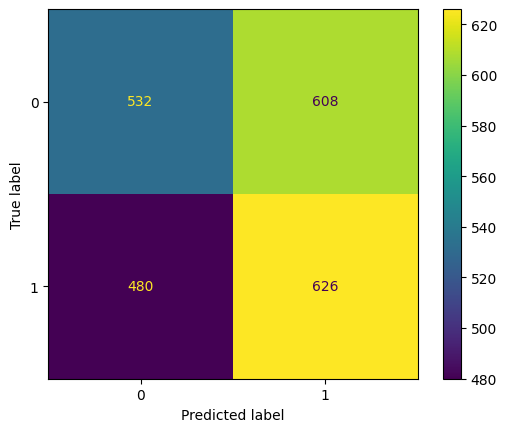

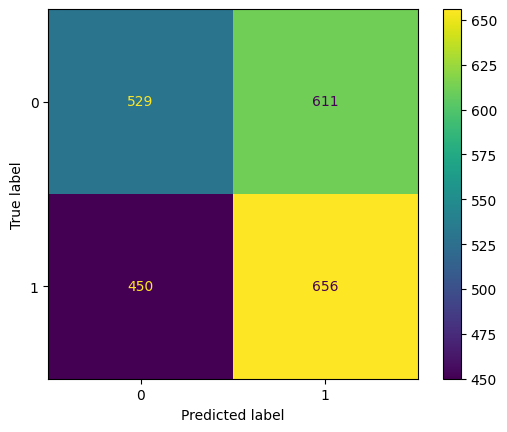

In [280]:
ConfusionMatrixDisplay.from_estimator(lr_gs_2.best_estimator_, X_test_2, y_test_2);
ConfusionMatrixDisplay.from_estimator(lr_gs.best_estimator_, X_test, y_test);

In [281]:
pause #импровизированная точка остановы

NameError: name 'pause' is not defined

# Работа продолжается...

## Настройка лучшей модели

Кроссвалидация и метрика тоночсти показала небольшое, но преимущество LGBM модели над остальными

Что более важно, матрица ошибок LGBM модели показала, что у LGBM модели самая высокая **специфичность**, т.е она заметно лучше остальных моделей предсказывает **падение цены**

**Отталкиваясь от данного факта, попробуем улучшить эту модель**

In [ ]:
sol_data.columns

### Попытка обучения LGBM №2

In [ ]:
model_lgbm_columns = ['target', 'ema_50', 'ema_100', 'ema_200', 'rsi', 'macd_line',
       'signal_line', 'macd_hist', 'stoch_rsi_k', 'stoch_rsi_d',
       'delta_ema_50', 'delta_ema_100', 'delta_ema_200']

In [ ]:
train_lgbm, test_lgbm = train_test_split(sol_data[model_lgbm_columns], shuffle=False, test_size=0.1)

In [ ]:
X_train_lgbm = train_lgbm.drop('target', axis=1)

In [ ]:
y_train_lgbm = train_lgbm['target']

In [ ]:
X_test_lgbm = test_lgbm.drop('target', axis=1)

In [ ]:
y_test_lgbm = test_lgbm['target']

In [ ]:
model_lgbm_2 = lgb.LGBMClassifier(random_state=RANDOM_STATE,  force_col_wise=True)

In [ ]:
param_grid_gbm = {
 'learning_rate': [0.01],
 'n_estimators': [250, 500, 1000],
 'max_depth': range(2,10),
 'num_leaves': range(2,10)
}

In [ ]:
lgbm_gs_2 = GridSearchCV(model_lgbm_2, param_grid_gbm, cv=tscv, scoring='accuracy', n_jobs=-1, verbose=2)

In [ ]:
lgbm_gs_2.fit(X_train_lgbm, y_train_lgbm)

In [ ]:
lgbm_score_2 = round((lgbm_gs_2.best_score_),4)

In [ ]:
print(f'Метрика accuracy_score на кроссвалидации для модели LGBM_2 равна {lgbm_score_2}')

In [ ]:
lgbm_prediction_2 = lgbm_gs_2.best_estimator_.predict(X_test_lgbm)

In [ ]:
lgbm_accuracy_2 = accuracy_score(y_test_lgbm, lgbm_prediction_2)

In [ ]:
print("Accuracy Score:", lgbm_accuracy_2)

In [ ]:
ConfusionMatrixDisplay.from_estimator(lgbm_gs_2.best_estimator_, X_test_lgbm, y_test_lgbm);

In [ ]:
importances_lgbm_2 = lgbm_gs_2.best_estimator_.feature_importances_

In [ ]:
importances_df_lgbm_2 = pd.DataFrame({'Feature': X_train_lgbm.columns, 'Importance': importances_lgbm_2})

In [ ]:
importances_df_lgbm_2 = importances_df_lgbm_2.sort_values('Importance', ascending=False)

In [ ]:
plt.figure(figsize=(10, 8))
sn.barplot(x='Importance', y='Feature', data=importances_df_lgbm_2, palette='Blues_d')
plt.title('Важность признаков LGBM')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.show()

### Попытка обучения №3

In [ ]:
m_col_3 = ['target',  'rsi', 'macd_line',
       'signal_line', 'macd_hist', 'stoch_rsi_k', 'stoch_rsi_d',
       'delta_ema_50', 'delta_ema_100', 'delta_ema_200']

In [ ]:
train_lgbm_3, test_lgbm_3 = train_test_split(sol_data[m_col_3], shuffle=False, test_size=0.1)

In [ ]:
X_train_lgbm_3 = train_lgbm_3.drop('target', axis=1)

In [ ]:
y_train_lgbm_3 = train_lgbm_3['target']

In [ ]:
X_test_lgbm_3 = test_lgbm_3.drop('target', axis=1)

In [ ]:
y_test_lgbm_3 = test_lgbm_3['target']

In [ ]:
model_lgbm_3 = lgb.LGBMClassifier(random_state=RANDOM_STATE,  force_col_wise=True)

In [ ]:
param_grid_gbm = {
 'learning_rate': [0.01],
 'n_estimators': [250, 500, 1000],
 'max_depth': range(2,10),
 'num_leaves': range(2,10)
}

In [ ]:
lgbm_gs_3 = GridSearchCV(model_lgbm_3, param_grid_gbm, cv=tscv, scoring='accuracy', n_jobs=-1, verbose=2)

In [ ]:
lgbm_gs_3.fit(X_train_lgbm_3, y_train_lgbm_3)

In [ ]:
lgbm_score_3 = round((lgbm_gs_3.best_score_),4)

In [ ]:
print(f'Метрика accuracy_score на кроссвалидации для модели LGBM_3 равна {lgbm_score_3}')

In [ ]:
lgbm_prediction_3 = lgbm_gs_3.best_estimator_.predict(X_test_lgbm_3)

In [ ]:
lgbm_accuracy_3 = accuracy_score(y_test_lgbm_3, lgbm_prediction_3)

In [ ]:
print("Accuracy Score:", lgbm_accuracy_3)

In [ ]:
ConfusionMatrixDisplay.from_estimator(lgbm_gs_3.best_estimator_, X_test_lgbm_3, y_test_lgbm_3);

In [ ]:
importances_lgbm_3 = lgbm_gs_3.best_estimator_.feature_importances_
importances_df_lgbm_3 = pd.DataFrame({'Feature': X_train_lgbm_3.columns, 'Importance': importances_lgbm_3})
importances_df_lgbm_3 = importances_df_lgbm_3.sort_values('Importance', ascending=False)

In [ ]:
plt.figure(figsize=(10, 8))
sn.barplot(x='Importance', y='Feature', data=importances_df_lgbm_3, palette='Blues_d')
plt.title('Важность признаков LGBM')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.show()

### Попытка обучения №4

In [ ]:
m_col_4 = ['target',  'rsi',
       'signal_line', 'macd_hist', 'stoch_rsi_k', 'stoch_rsi_d',
       'delta_ema_50', 'delta_ema_100', 'delta_ema_200']

In [ ]:
train_lgbm, test_lgbm = train_test_split(sol_data[m_col_4], shuffle=False, test_size=0.1)

In [ ]:
X_train_lgbm_4 = train_lgbm.drop('target', axis=1)

In [ ]:
y_train_lgbm_4 = train_lgbm['target']

In [ ]:
X_test_lgbm_4 = test_lgbm.drop('target', axis=1)

In [ ]:
y_test_lgbm_4 = test_lgbm['target']

In [ ]:
model_lgbm_4 = lgb.LGBMClassifier(random_state=RANDOM_STATE,  force_col_wise=True)

In [ ]:
param_grid_gbm = {
 'learning_rate': [0.01],
 'n_estimators': [250, 500, 1000],
 'max_depth': range(2,10),
 'num_leaves': range(2,10)
}

In [ ]:
lgbm_gs_4 = GridSearchCV(model_lgbm_4, param_grid_gbm, cv=tscv, scoring='accuracy', n_jobs=-1, verbose=2)

In [ ]:
lgbm_gs_4.fit(X_train_lgbm_4, y_train_lgbm_4)

In [ ]:
lgbm_score_4 = round((lgbm_gs_4.best_score_),4)

In [ ]:
print(f'Метрика accuracy_score на кроссвалидации для модели LGBM_4 равна {lgbm_score_4}')

In [ ]:
lgbm_prediction_4 = lgbm_gs_4.best_estimator_.predict(X_test_lgbm_4)
lgbm_accuracy_4 = accuracy_score(y_test_lgbm_4, lgbm_prediction_4)
print("Accuracy Score:", lgbm_accuracy_4)

In [ ]:
ConfusionMatrixDisplay.from_estimator(lgbm_gs_4.best_estimator_, X_test_lgbm_4, y_test_lgbm_4);

In [ ]:
importances_lgbm_4 = lgbm_gs_4.best_estimator_.feature_importances_
importances_df_lgbm_4 = pd.DataFrame({'Feature': X_train_lgbm_4.columns, 'Importance': importances_lgbm_4})
importances_df_lgbm_4 = importances_df_lgbm_4.sort_values('Importance', ascending=False)

In [ ]:
plt.figure(figsize=(10, 8))
sn.barplot(x='Importance', y='Feature', data=importances_df_lgbm_4, palette='Blues_d')
plt.title('Важность признаков LGBM')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.show()

### Попытка обучения №5

In [ ]:
m_col_5 = ['target',  'rsi', 'macd_hist', 'stoch_rsi_k', 'stoch_rsi_d',
       'delta_ema_50', 'delta_ema_100', 'delta_ema_200']

In [ ]:
train_lgbm, test_lgbm = train_test_split(sol_data[m_col_5], shuffle=False, test_size=0.1)
X_train_lgbm = train_lgbm.drop('target', axis=1)
y_train_lgbm = train_lgbm['target']
X_test_lgbm = test_lgbm.drop('target', axis=1)
y_test_lgbm = test_lgbm['target']

In [ ]:
model_lgbm_5 = lgb.LGBMClassifier(random_state=RANDOM_STATE,  force_col_wise=True)

In [ ]:
param_grid_gbm = {
 'learning_rate': [0.01],
 'n_estimators': [250, 500, 1000],
 'max_depth': range(2,10),
 'num_leaves': range(2,10)
}

In [ ]:
lgbm_gs_5 = GridSearchCV(model_lgbm_5, param_grid_gbm, cv=tscv, scoring='accuracy', n_jobs=-1, verbose=2)

In [ ]:
lgbm_gs_5.fit(X_train_lgbm, y_train_lgbm)

In [ ]:
lgbm_score_5 = round((lgbm_gs_5.best_score_),4)
print(f'Метрика accuracy_score на кроссвалидации для модели LGBM_5 равна {lgbm_score_5}')

In [ ]:
lgbm_prediction_5 = lgbm_gs_5.best_estimator_.predict(X_test_lgbm)
lgbm_accuracy_5 = accuracy_score(y_test_lgbm, lgbm_prediction_5)
print("Accuracy Score:", lgbm_accuracy_5)

In [ ]:
ConfusionMatrixDisplay.from_estimator(lgbm_gs_5.best_estimator_, X_test_lgbm, y_test_lgbm);

### Промежуточный итог 5 моделей LGBM

In [ ]:
cross_val_scores = lgbm_score, lgbm_score_2, lgbm_score_3, lgbm_score_4, lgbm_score_5
test_scores = lgbm_accuracy, lgbm_accuracy_2, lgbm_accuracy_3, lgbm_accuracy_4, lgbm_accuracy_5

In [ ]:
models = ['LGBM','LGBM_2','LGBM_3','LGBM_4','LGBM_5']

In [ ]:
results_lgbm = pd.DataFrame({
    'Models': models,
    'Cross_val_score': cross_val_scores,
    'Test_score': test_scores
                          })

In [ ]:
results_lgbm = results_lgbm.sort_values('Cross_val_score', ascending=False)

In [ ]:
results_lgbm = results_lgbm.set_index('Models')

In [ ]:
results_lgbm